# ⚡️ Training a spiking network with Jax

## Requirements and housekeeping

In [1]:
# - Switch off warnings
from __future__ import annotations
import warnings
warnings.filterwarnings('ignore')

# - Rockpool imports
from rockpool import TSEvent, TSContinuous
from rockpool.nn.modules import LIFJax, LinearJax, ExpSynJax
from rockpool.nn.modules.jax.jax_lif_ode import LIFODEJax
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Typing
from typing import Callable, Dict, Tuple
import types

# - Numpy
import numpy as np
import copy
import seaborn as sns
from rockpool.devices.dynapse.dynapsim import DynapSim

# - Pretty printing
try:
    from rich import print
except:
    pass

# TQDM
from tqdm.autonotebook import tqdm

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## Signal generation from frozen noise task
We will use a single feed-forward layer of spiking neurons to convert a chosen pattern of random input spikes over time, into a pre-defined temporal signal with complex dynamics.

The network architecture is strictly feedforward, but the spiking neurons nevertheless contain temporal dynamics in their synaptic and membrane signals, with explicit time constants.

Some number of input channels `Nin` will contain independent Poisson spikes at some rate `spiking_prob/dt`. A single output channel should generate a chirp signal with increasing frequency, up to a maximum of `chirp_freq_factor`. You can play with these parameters below.

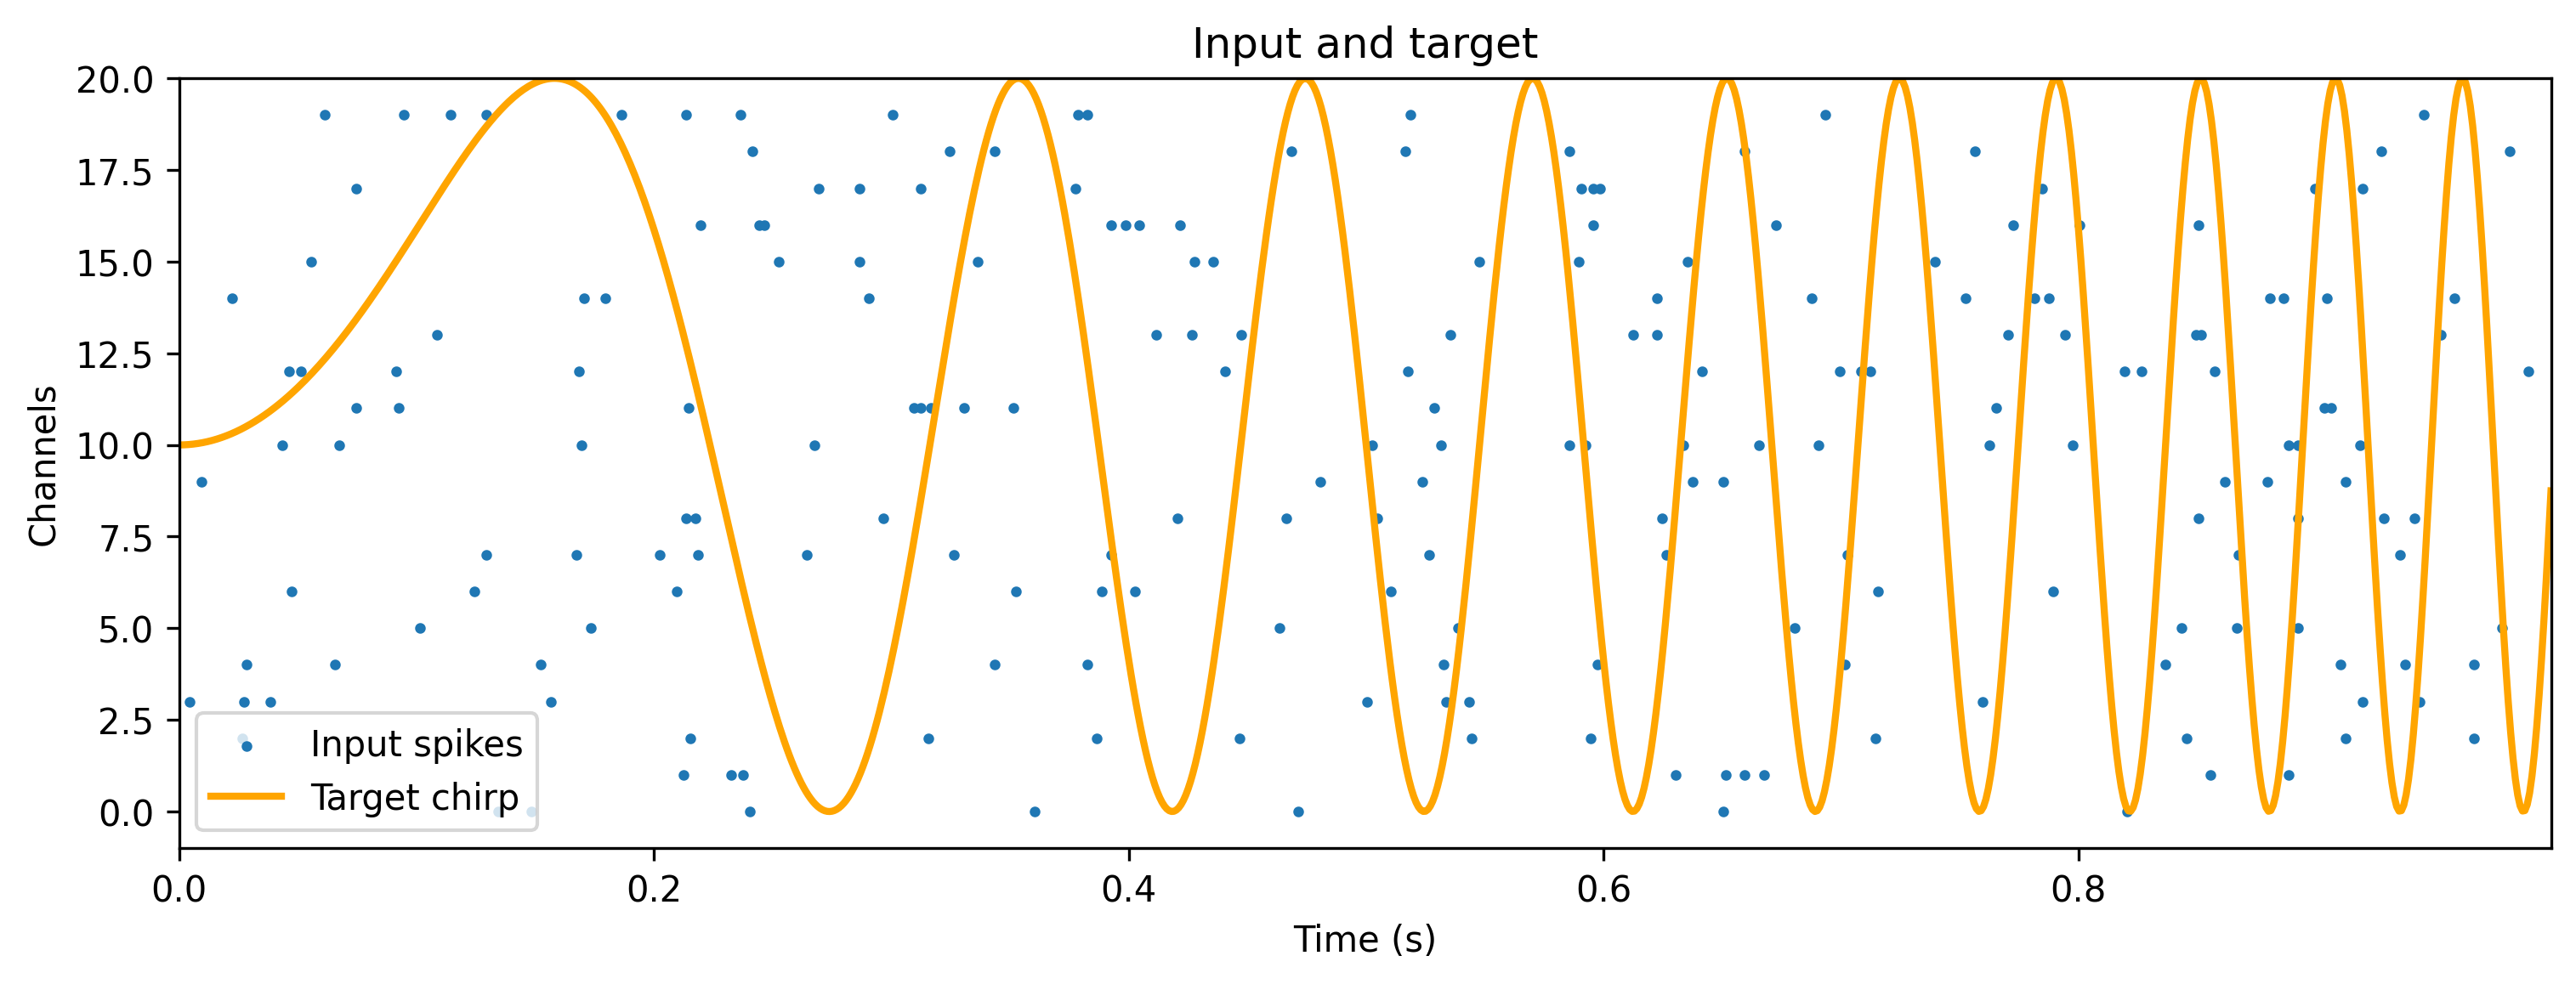

In [2]:
# - Define input and target
Nin = 20
dt = 1e-3
chirp_freq_factor = 10
dur_input = 1000e-3

# - Generate a time base
T = int(np.round(dur_input / dt))
timebase = np.linspace(0, (T-1) * dt, T)

# - Generate a chirp signal as a target
chirp = np.atleast_2d(np.sin(timebase * 2 * np.pi * (timebase * chirp_freq_factor))).T
target_ts = TSContinuous(timebase, chirp, periodic = True, name = 'Target chirp')

# - Generate a Poisson frozen random spike train
spiking_prob = .01
input_sp_raster = np.random.rand(T, Nin) < spiking_prob
input_sp_ts = TSEvent.from_raster(input_sp_raster, name = 'Input spikes', periodic = True, dt = dt)

# - Plot the input and target signals
plt.figure()
input_sp_ts.plot(s = 4)
(target_ts * Nin/2 + Nin/2).plot(color="orange", lw=2)
plt.legend()
plt.title('Input and target');

## LIF neuron
The spiking neuron we will use is a leaky integrate-and-fire spiking neuron ("LIF" neuron). This neuron recevies input spike trains $S_{in}(t) = \sum_j\delta(t-t_j)$, which are integrated via weighted exponential synapses. Synaptic currents are then integrated into a neuron state ("membrane potential") $V_{mem}$.

The neuron obeys the dynamics
$$\tau_{mem}\cdot\dot{V}_{mem} + V_{mem} = {I}_{syn} + I_{bias} + \sigma\zeta(t)$$
$$\tau_{syn}\cdot\dot{I}_{syn} + I_{syn} = 0$$
$$I_{syn} += W_{in} \cdot S_{in}(t)$$

Where $\tau_{mem}$ and $\tau_{syn}$ are membrane and synaptic time constants; $I_{bias}$ is a constant bias current for each neuron; $\sigma\zeta(t)$ is a white noise process with std. dev. $\sigma$.

Output spikes are generated when $V_{mem}$ crosses the firing threshold $V_{th} = 0$. This process generates a spike train $S(t)$ as a series of delta functions, and causes a subtractive reset of $V_{mem}$:

$$V_{mem} > V_{th} \rightarrow S(t) = H(V_{mem}(t)), V_{mem} = V_{mem} - 1$$

The analog output signal is generated using a surrogate
$$U(t) = \tanh(x + 1) / 2 + 0.5$$

The output of the network $o(t)$ is therefore given by
$$o(t) = W_{out} \cdot S(t)$$

## Build a network
The network architecture is a single feedforward layer, with weighted spiking inputs and outputs. Spiking is generated via a function that provides a surrogate gradient in the backwards pass. This permits propagation of an error gradient through the layer, making gradient-descent training possible.

For this regression task we will also use an exponential synapse layer to perfprm temporal smoothing of the output. Regressing to a smooth signal is much easier with a continuous output signal, than using the spike deltas alone.

In [3]:
# - Network size
Nin = 20
N1 = 40
N2 = 20
N3 = 10
input_scale = 20.

In [4]:
# - Generate a network using the sequential combinator
modFFwd = Sequential(
    LinearJax((Nin, N1), has_bias = False), # 30x20
    LIFODEJax((N1, N1), dt = dt, has_rec=True), # 40x40
    LinearJax((N1, N2), has_bias = False), # 30x20
    LIFODEJax((N2, N2), dt = dt, has_rec=True), # 40x40
    LinearJax((N2, N3), has_bias = False), # 30x20
    LIFODEJax((N3, N3), dt = dt, has_rec=True), # 40x40
)

print(modFFwd)

JaxSequential  with shape (20, 10) {
    LinearJax '0_LinearJax' with shape (20, 40)
    LIFODEJax '1_LIFODEJax' with shape (40, 40)
    LinearJax '2_LinearJax' with shape (40, 20)
    LIFODEJax '3_LIFODEJax' with shape (20, 20)
    LinearJax '4_LinearJax' with shape (20, 10)
    LIFODEJax '5_LIFODEJax' with shape (10, 10)
}


## Simulate initial state of network
If we simulate the untrained network with our random input spikes, we don't expect anything sensible to come out. Let's do this, and take a look at how the network behaves.

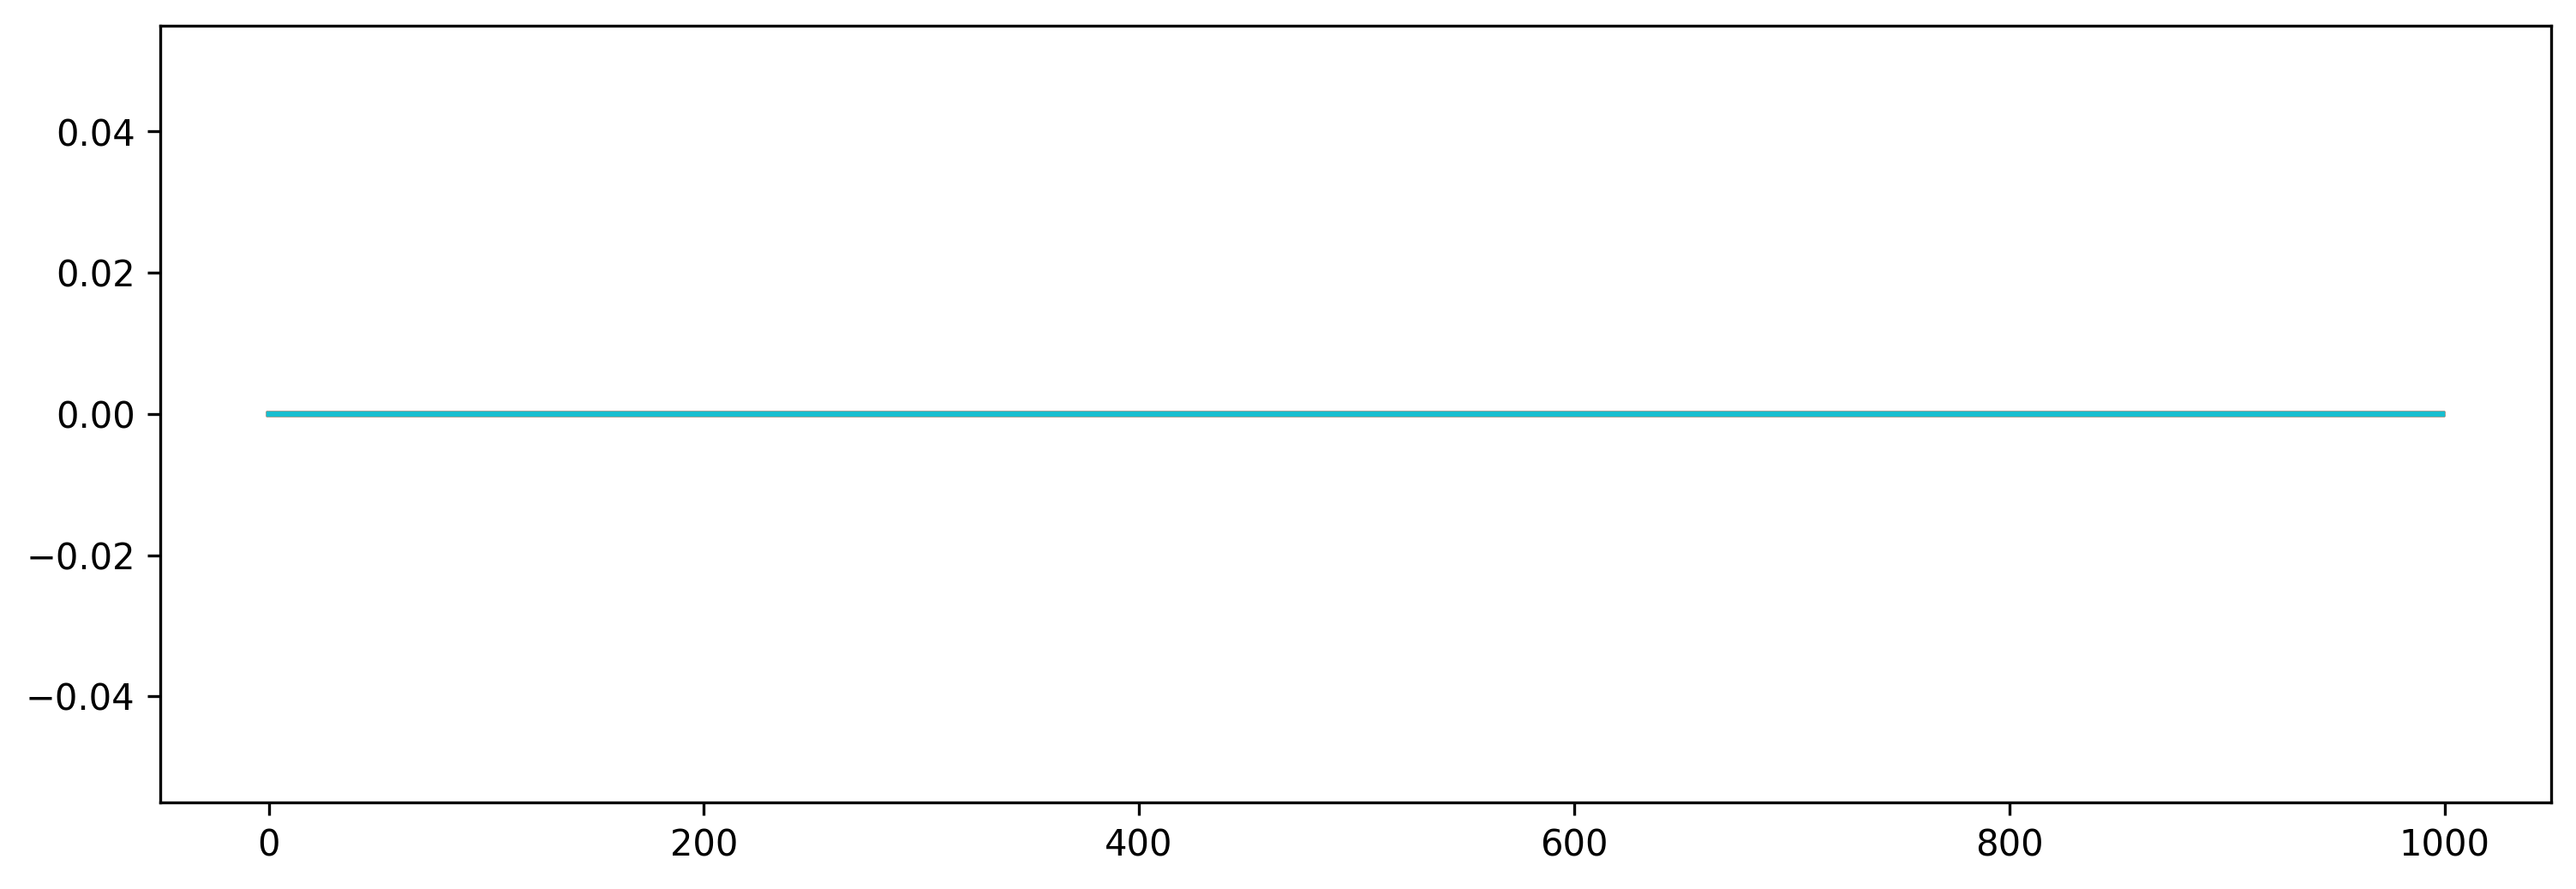

In [5]:
# - Randomise the network state
modFFwd.reset_state()

# - Evolve with the frozen noise spiking input
tsOutput, new_state, record_dict = modFFwd(input_sp_raster * input_scale, record = True)

# - Plot the analog output
plt.figure()
plt.plot(tsOutput[0]);

In [6]:
# - Make a function that converts ``record_dict``
def plot_record_dict(rd):
    Vmem_ts = TSContinuous.from_clocked(rd['1_LIFODEJax']['vmem'][0], dt, name = 'Membrane potential $V_{mem}$')
    U_ts = TSContinuous.from_clocked(rd['1_LIFODEJax']['U'][0], dt, name = 'Surrogate output $U$')
    Isyn_ts = TSContinuous.from_clocked(rd['1_LIFODEJax']['isyn'][0, :, :, 0], dt, name = 'Synaptic currents $I_{syn}$')
    spikes_ts = TSEvent.from_raster(rd['1_LIFODEJax']['spikes'][0], dt, name = 'LIF layer spikes')

    # - Plot the internal activity of selected neurons
    plt.figure()
    Vmem_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    U_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    Isyn_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    spikes_ts.plot(s=4);
    
# plot_record_dict(record_dict)

In [7]:
spiking_prob = .01
sp_rand_ts = np.random.rand(T, Nin) < spiking_prob

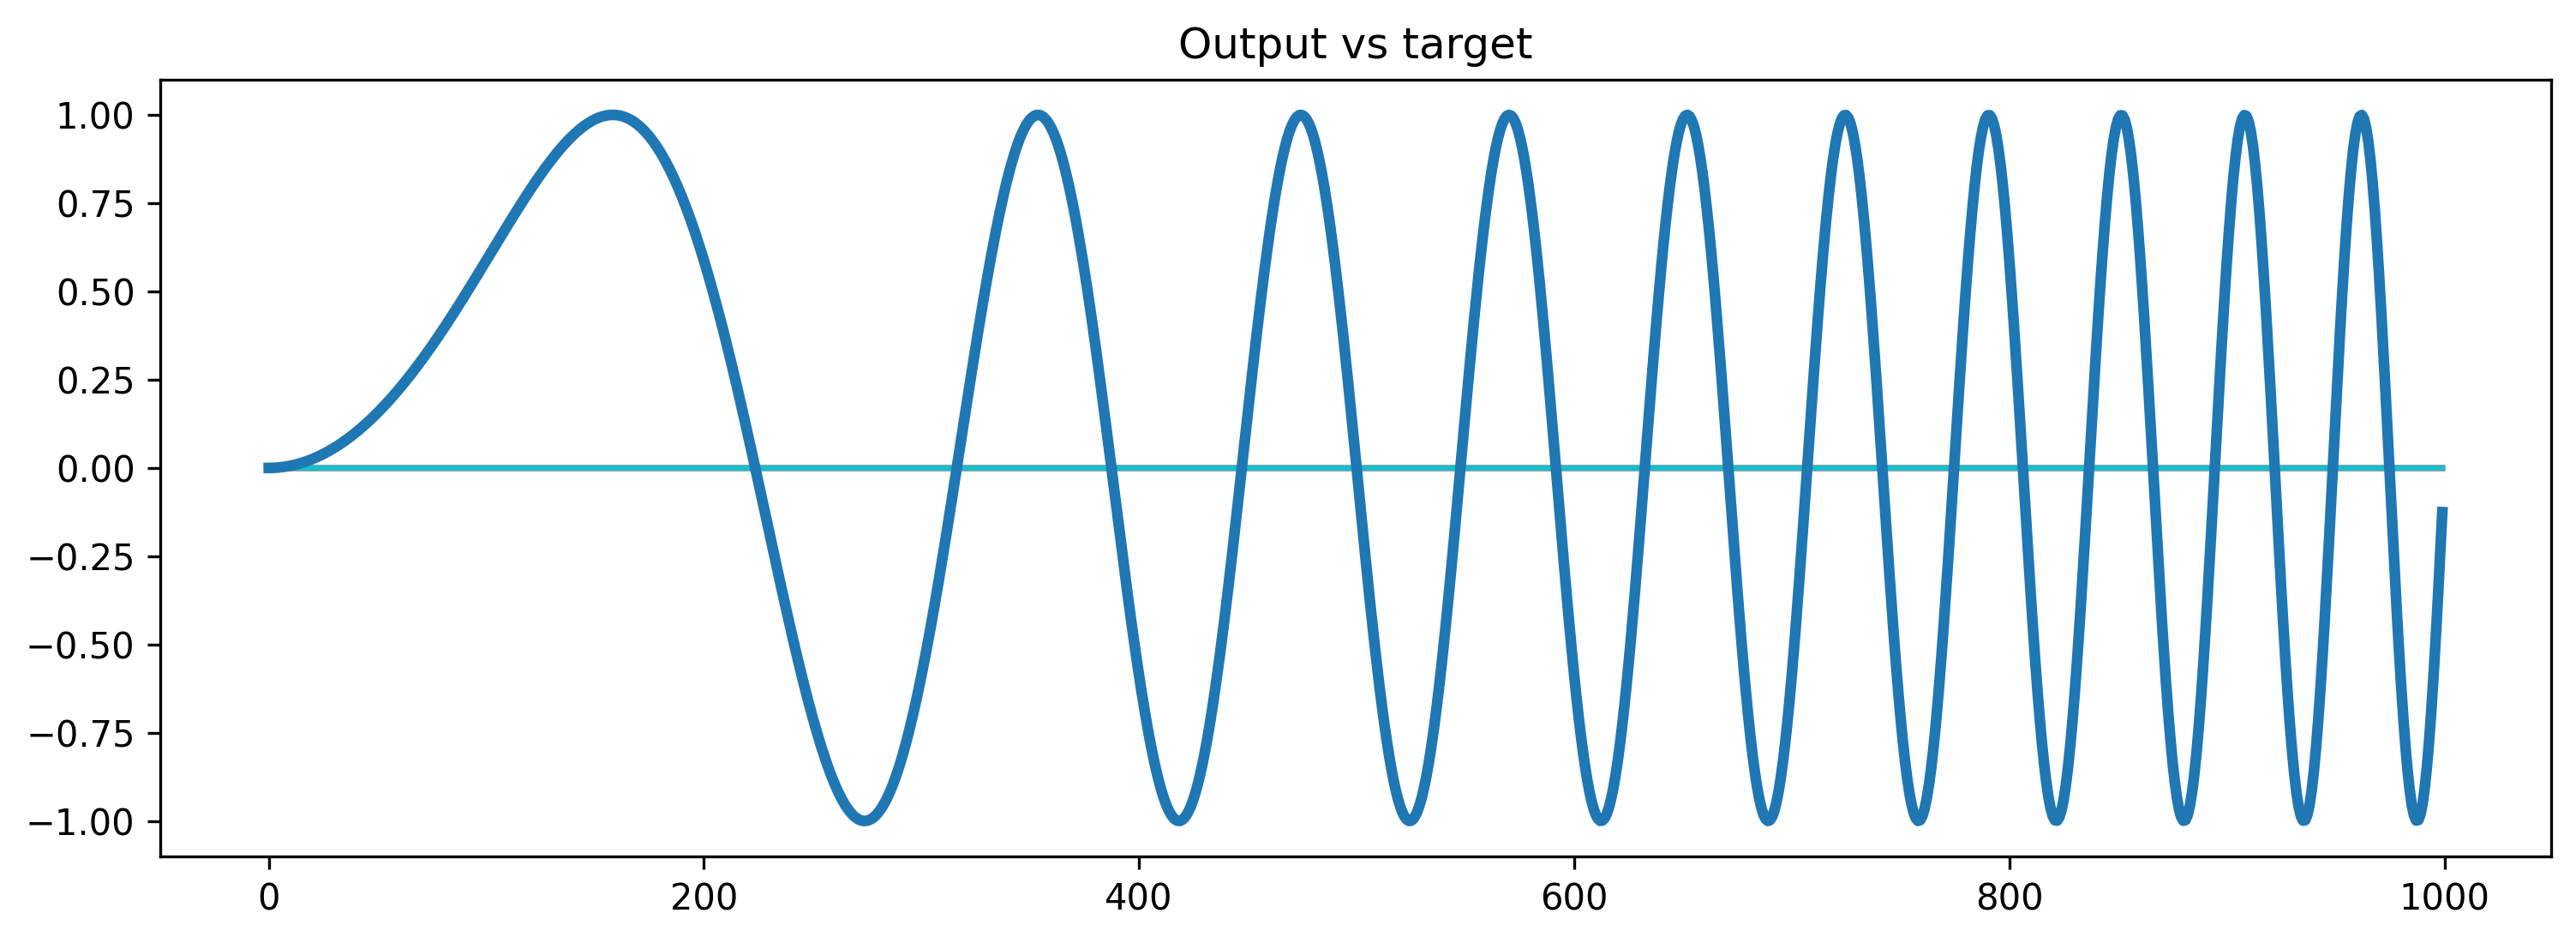

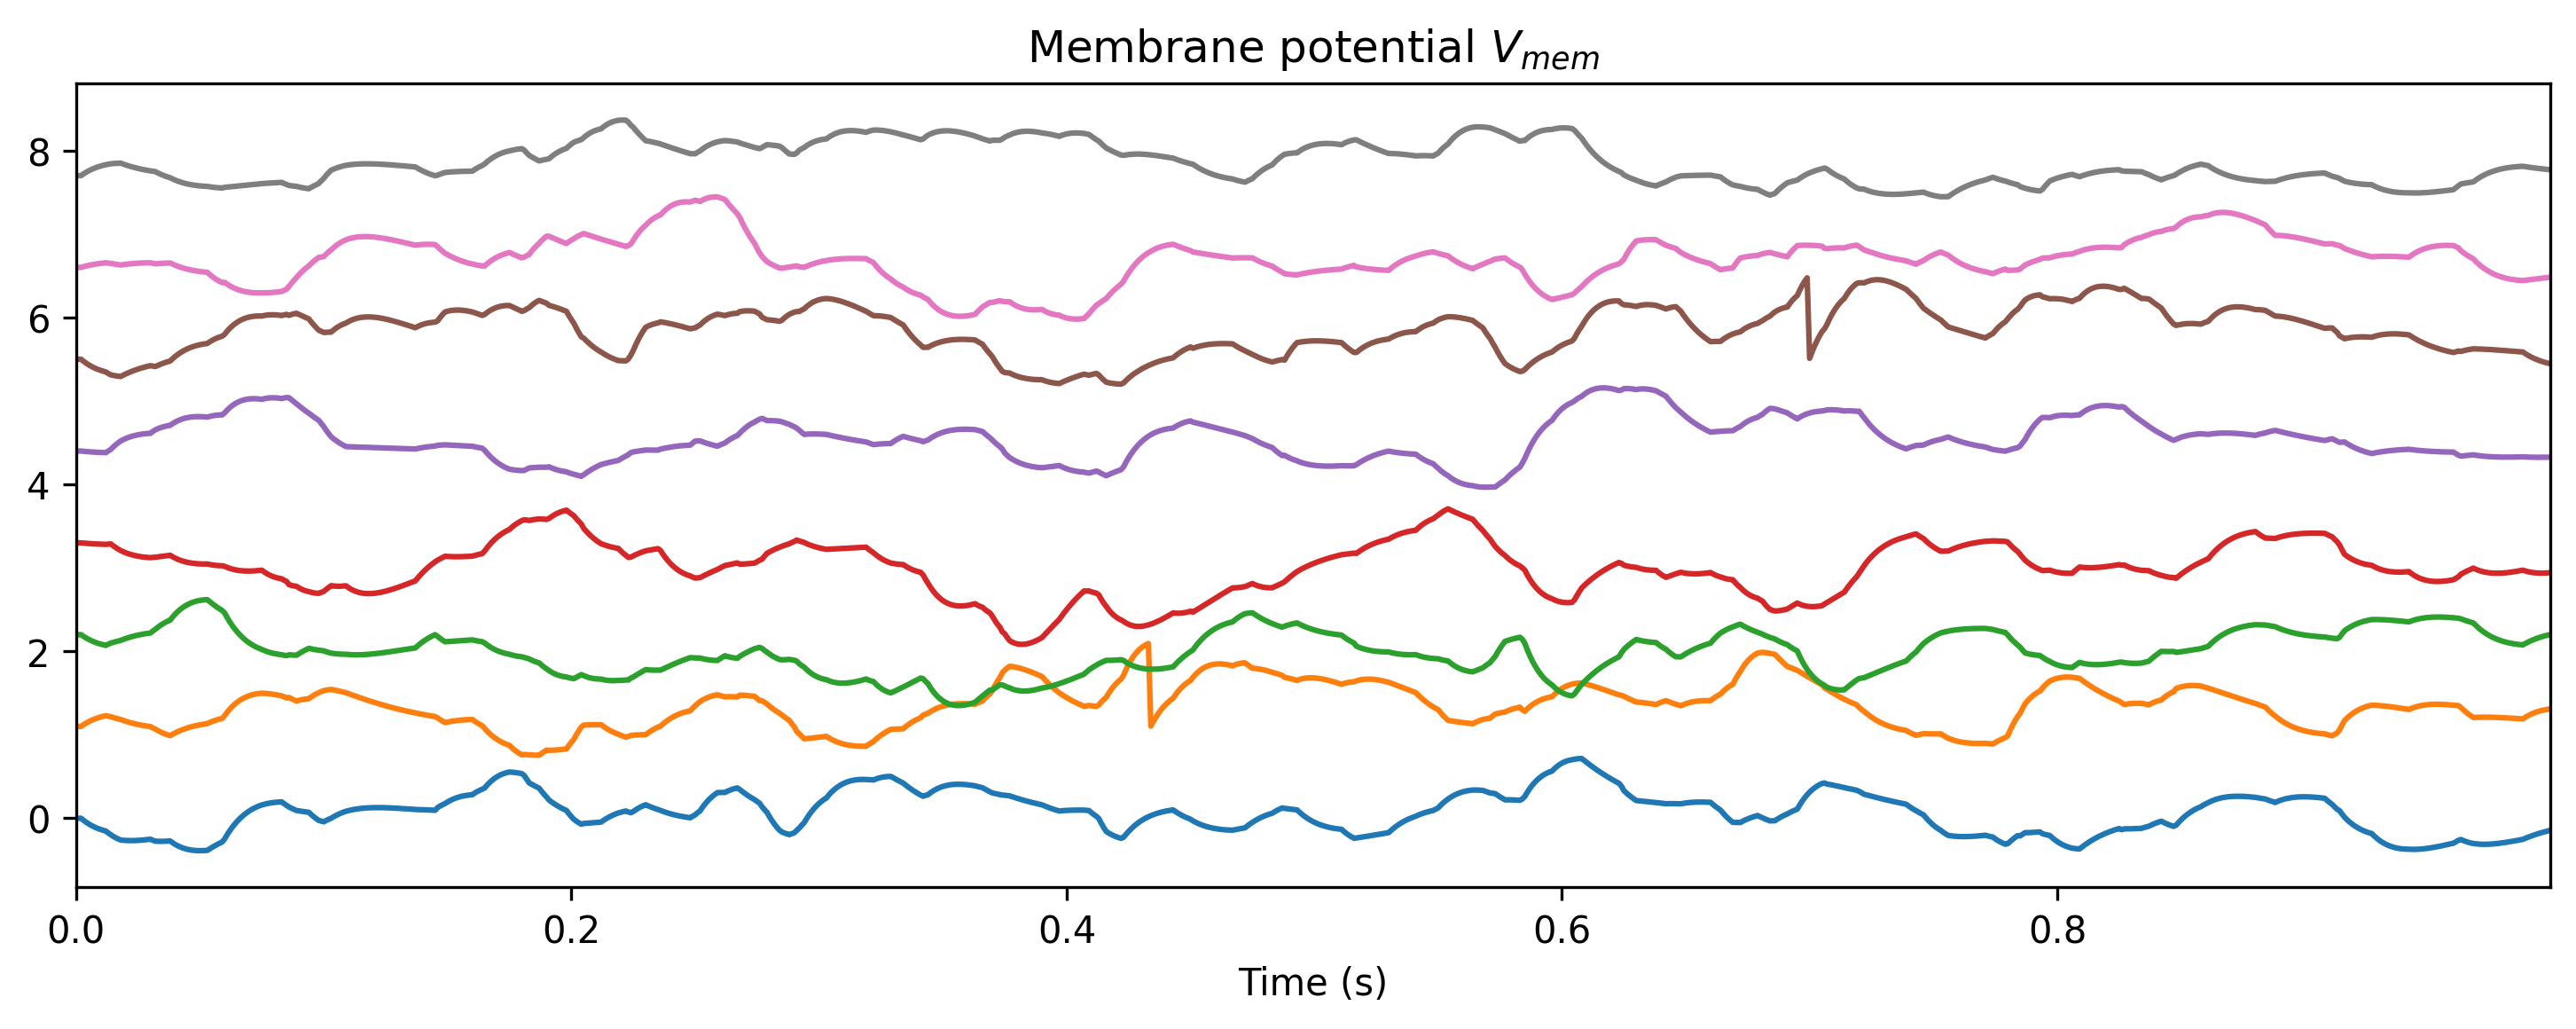

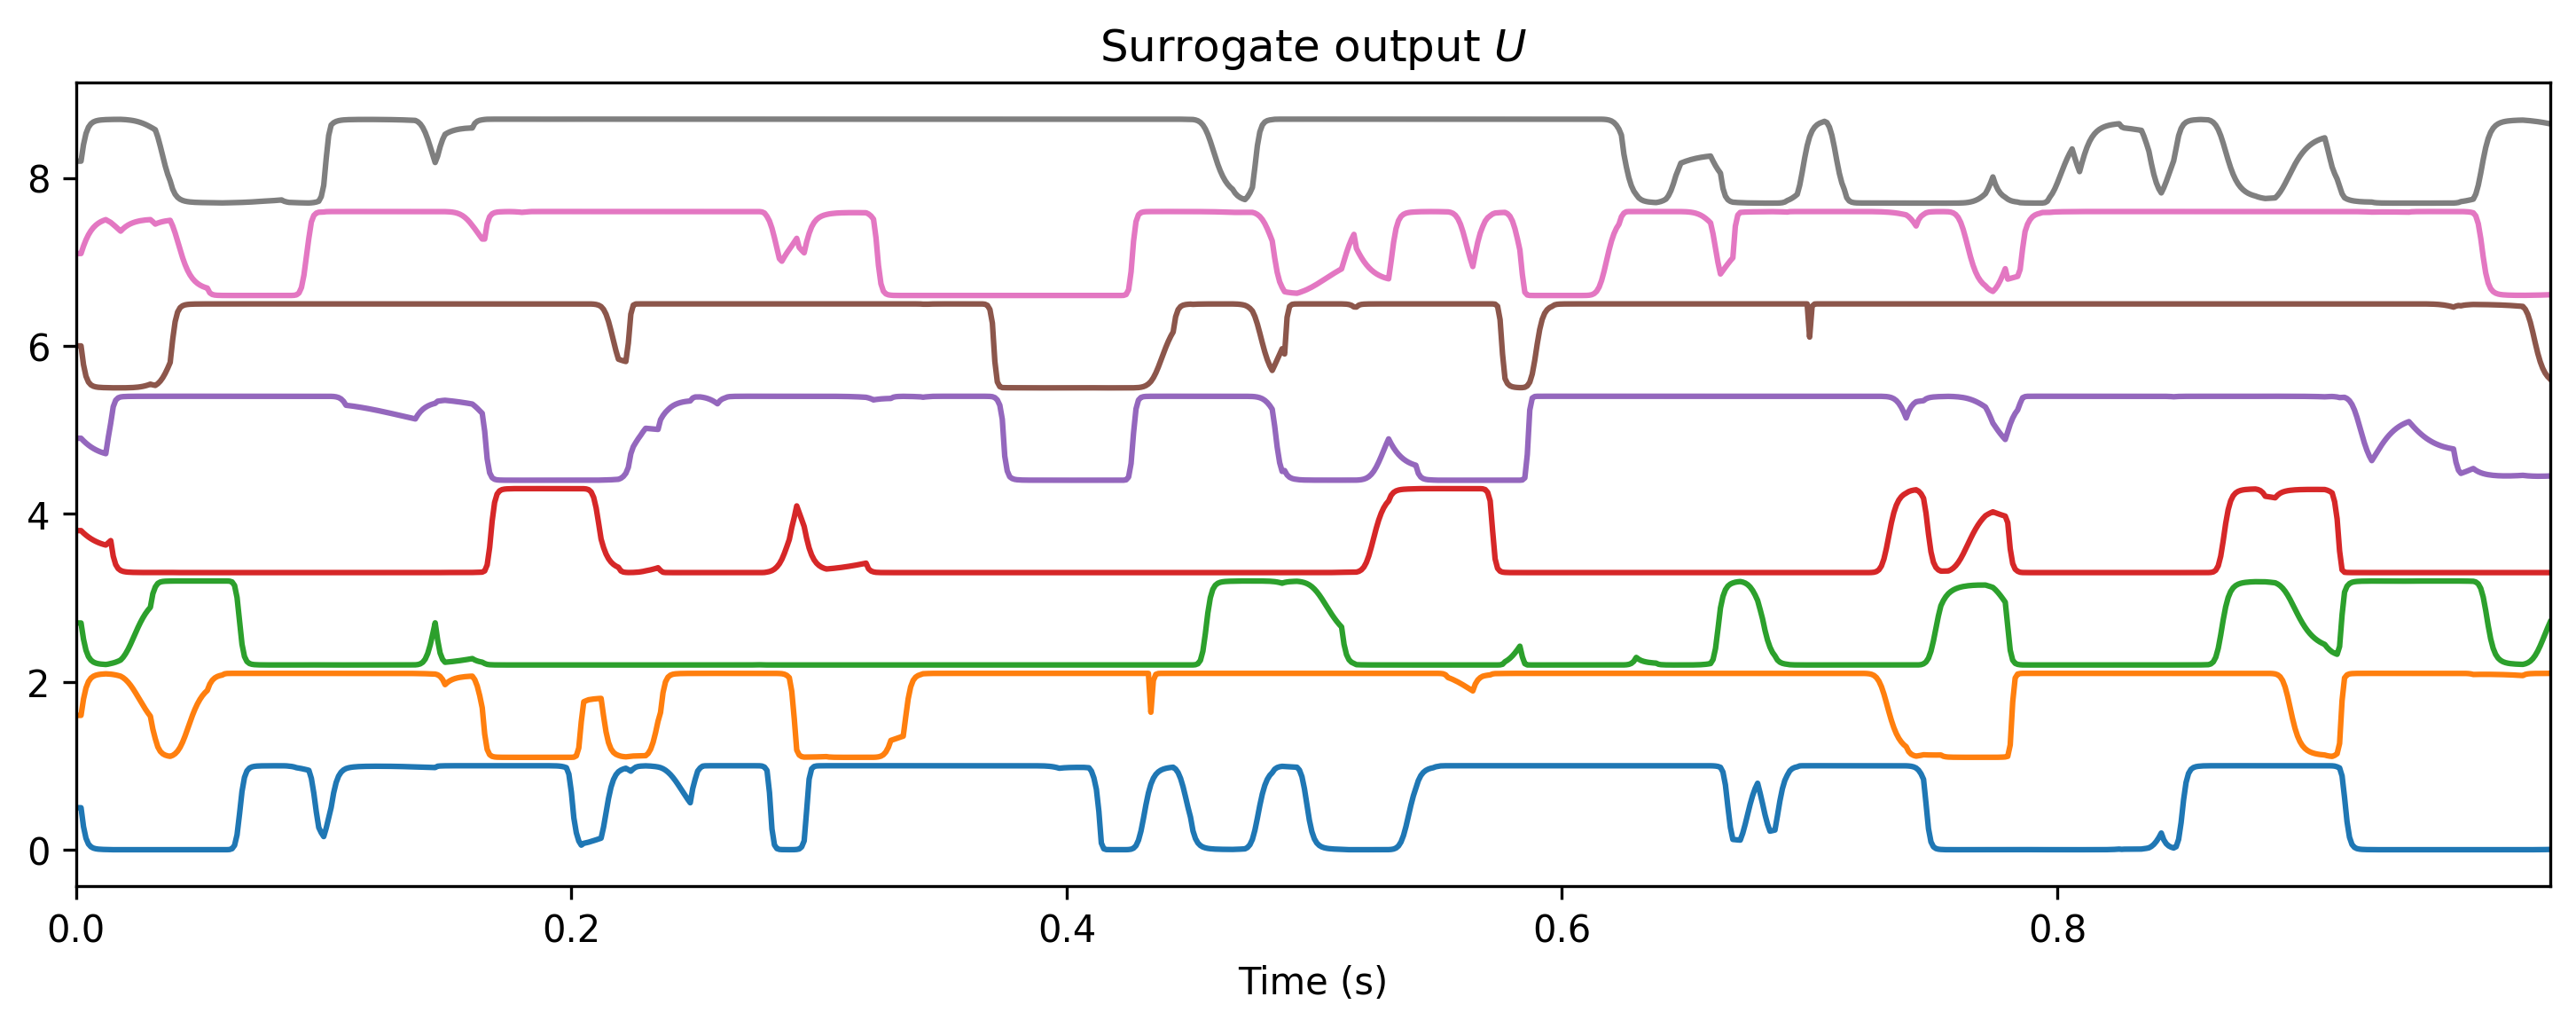

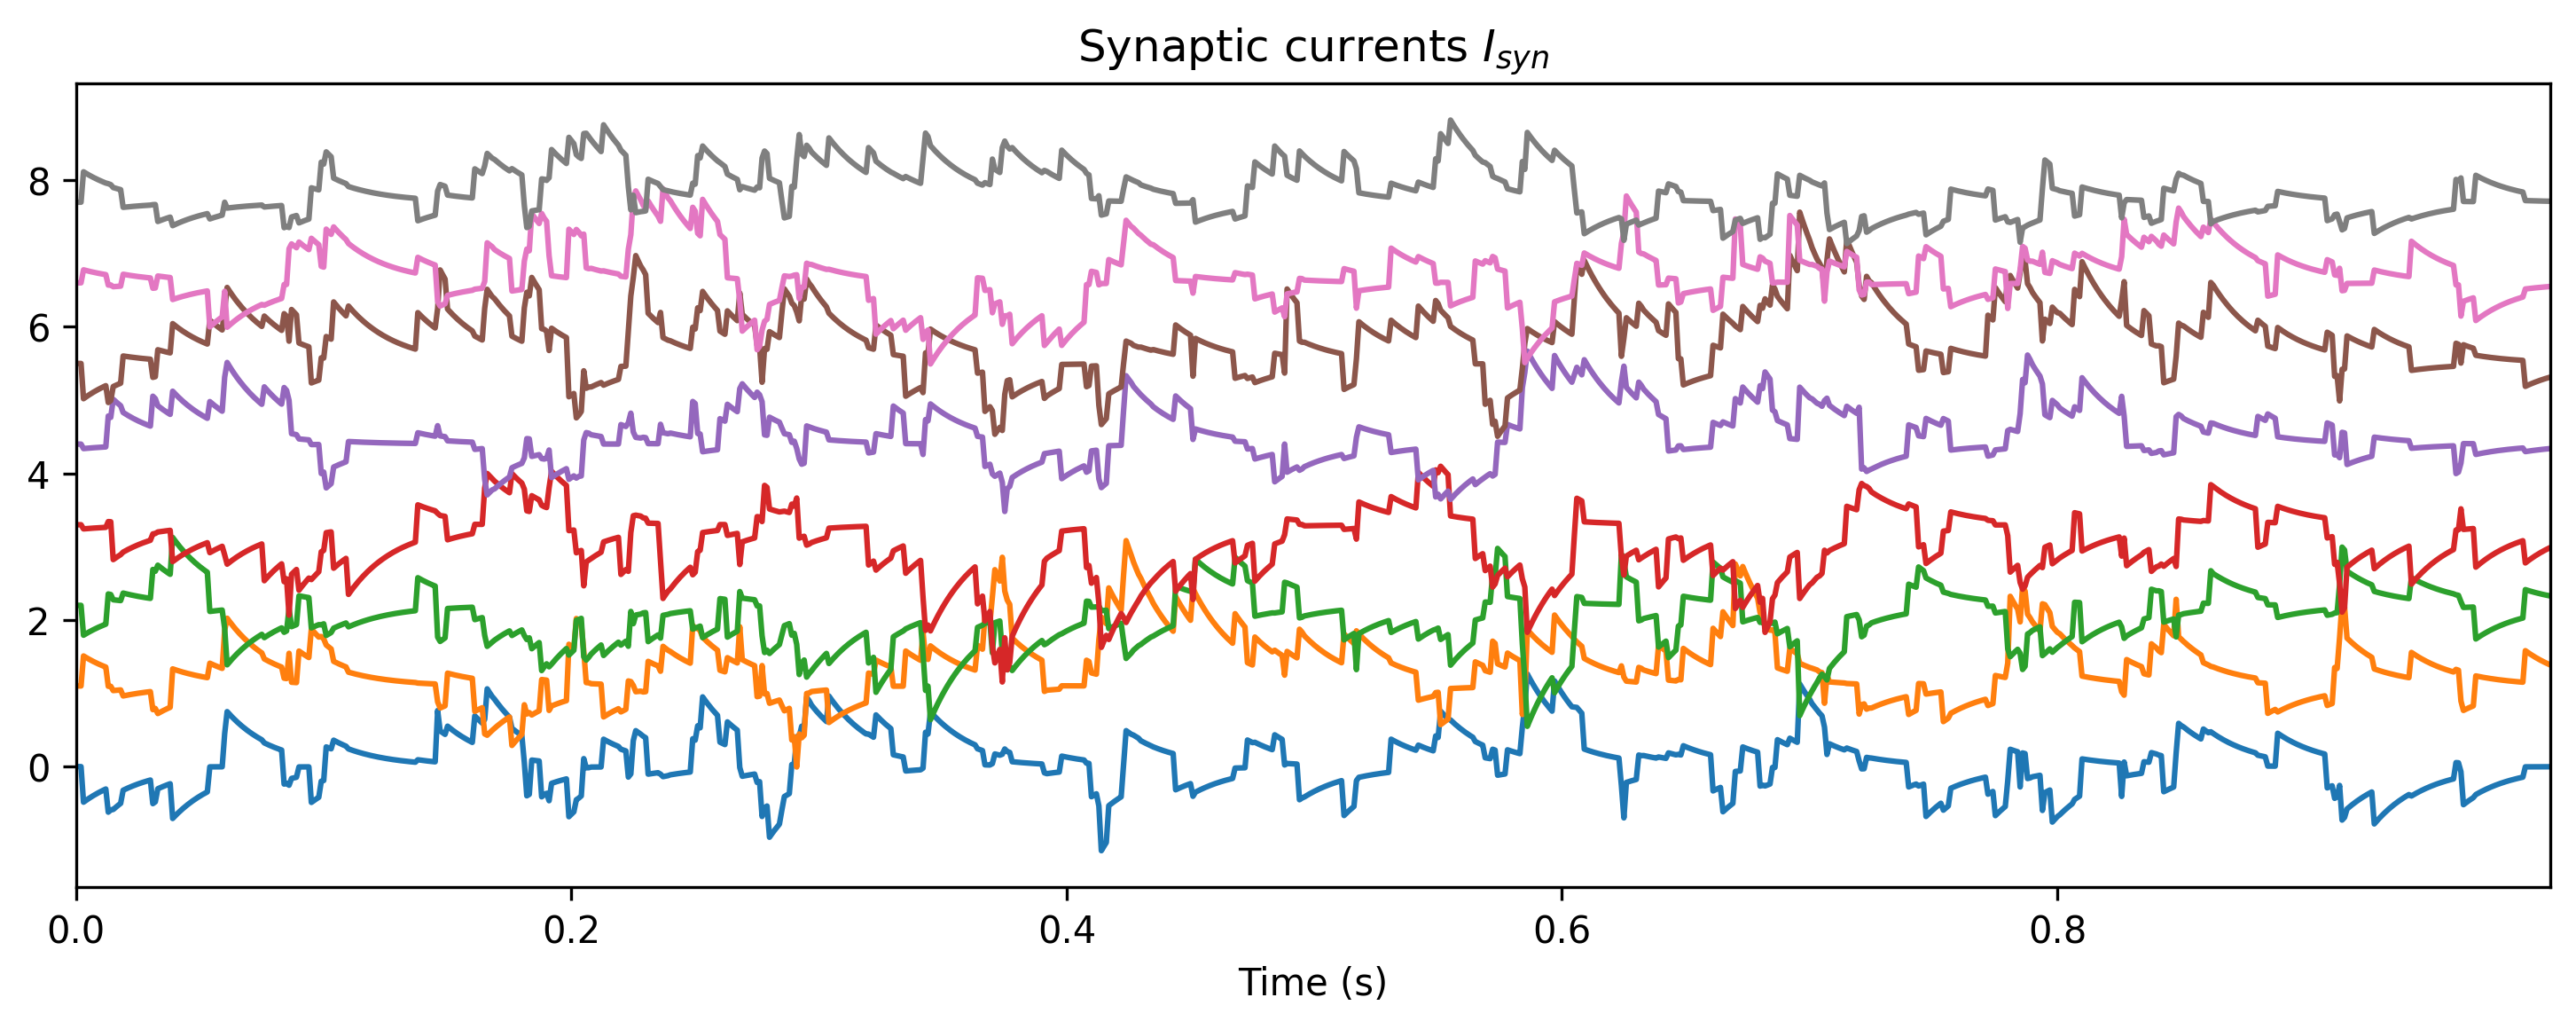

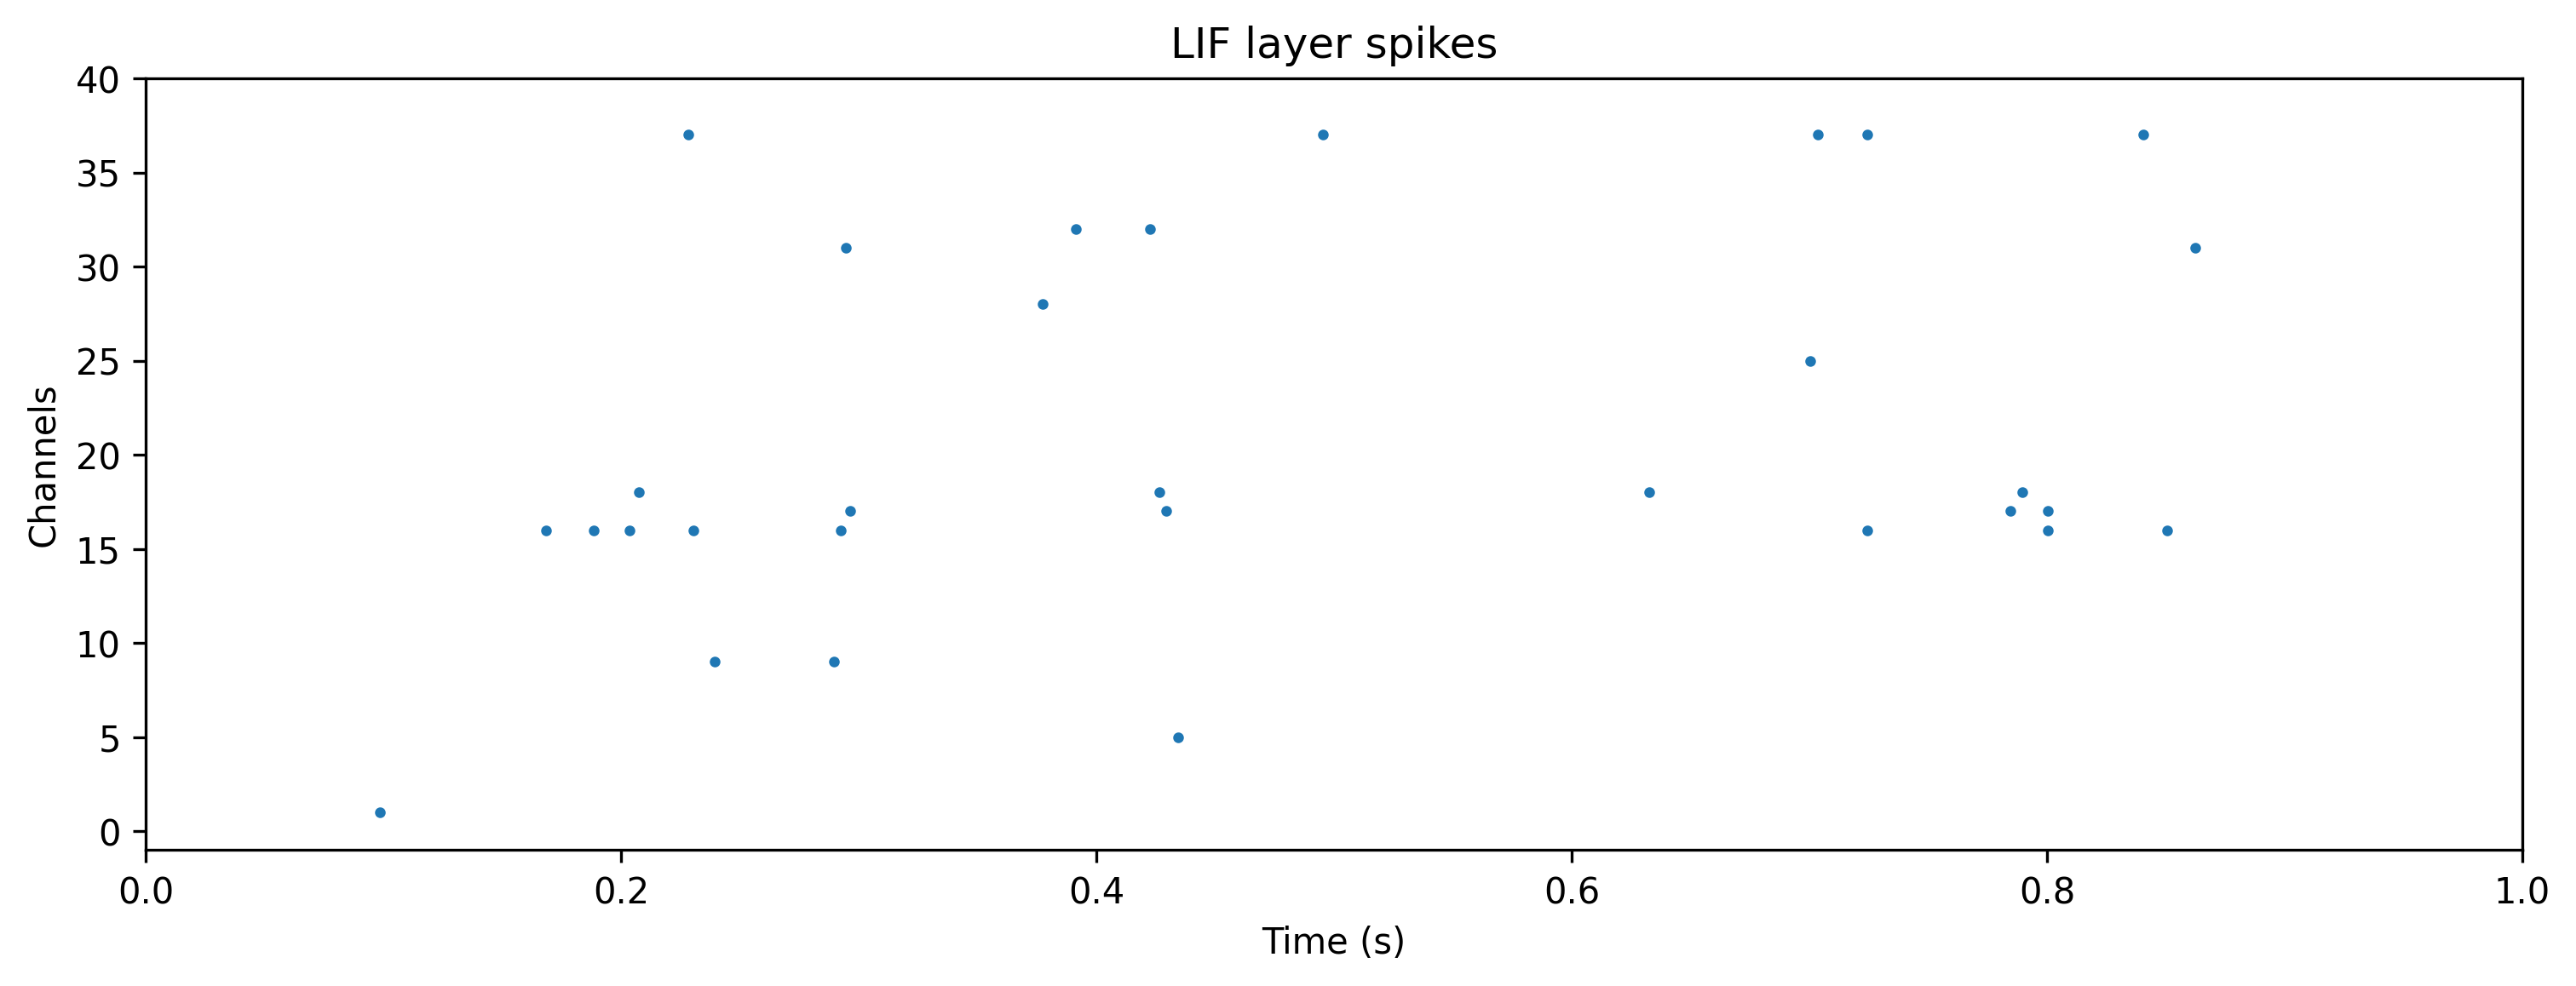

In [8]:
# # - Simulate with trained parameters
# modFFwd = modFFwd.set_attributes(get_params(opt_state))
modFFwd = modFFwd.reset_state()
output_ts, _, record_dict = modFFwd(sp_rand_ts * input_scale)

# - Compare the output to the target
plt.plot(output_ts[0])
plt.plot(chirp, lw=3)
plt.title('Output vs target')

# - Plot the internal state of selected neurons
plot_record_dict(record_dict)

As expected, the network doesn't do anything sensible with data it has never seen.

## Summary
This approach can be used identically to train recurrent spiking networks, as well as multi-layer (i.e. deep) networks.

In [9]:
from rockpool.devices.dynapse.graph import DynapseNeurons

In [10]:
from rockpool.graph.utils import bag_graph, find_recurrent_modules

mod_graph = modFFwd.as_graph()
nodes, modules = bag_graph(mod_graph)
rec_modules = find_recurrent_modules(mod_graph)

In [11]:
modules

[LinearWeights "LinearJax_'0_LinearJax'_11600087312" with 20 input nodes -> 40 output nodes,
 LinearWeights "LIFODEJax_recurrent_'1_LIFODEJax'_11599941488" with 40 input nodes -> 40 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'1_LIFODEJax'_11599941488" with 40 input nodes -> 40 output nodes,
 LinearWeights "LinearJax_'2_LinearJax'_11600093408" with 40 input nodes -> 20 output nodes,
 LinearWeights "LIFODEJax_recurrent_'3_LIFODEJax'_11595857680" with 20 input nodes -> 20 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'3_LIFODEJax'_11595857680" with 20 input nodes -> 20 output nodes,
 LinearWeights "LinearJax_'4_LinearJax'_11595857728" with 20 input nodes -> 10 output nodes,
 LinearWeights "LIFODEJax_recurrent_'5_LIFODEJax'_11281466800" with 10 input nodes -> 10 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'5_LIFODEJax'_11281466800" with 10 input nodes -> 10 output nodes]

In [12]:
from rockpool.devices.dynapse.config.transform import DFA_Placement, NPGrid, get_grid_lines, transformer
from rockpool.graph.graph_base import GraphModule
from rockpool.graph.graph_modules import LinearWeights
from typing import  Optional
from rockpool.graph.graph_modules import LIFNeuronWithSynsRealValue
import re
from typing import List
from rockpool.devices.dynapse.mapper import DynapseGraphWrapper, mapper
# mod = network_from_graph(mod_graph)
from copy import deepcopy

In [13]:
mod_trans = transformer(deepcopy(mod_graph))

In [14]:
mod_trans

GraphHolder "JaxSequential__11595850528_transformed_SE_11591612016" with 20 input nodes -> 70 output nodes

In [15]:
modFFwd[1].__dict__

{'_ModuleBase__registered_attributes': {'rng_key': [array([563860058,  79649751], dtype=uint32),
   'State',
   None,
   <function rockpool.parameters.ParameterBase.__init__.<locals>.<lambda>(_)>,
   (2,)],
  'w_rec': [array([[ 0.1116006 , -0.24755469,  0.25872403, ..., -0.16087206,
           -0.30053374,  0.27820218],
          [-0.31621215,  0.05078341, -0.20812091, ..., -0.21006581,
            0.0315435 , -0.1512281 ],
          [-0.26491198, -0.09791964,  0.31504834, ...,  0.25166616,
           -0.15609773,  0.15000743],
          ...,
          [-0.11421438,  0.27428836,  0.19449145, ...,  0.21967754,
            0.14756401, -0.27110636],
          [-0.2651038 ,  0.22421357, -0.07879334, ...,  0.32491267,
           -0.32239178,  0.01068661],
          [ 0.08206575,  0.35089752, -0.24091478, ...,  0.19197711,
            0.06452296,  0.11750331]], dtype=float32),
   'Parameter',
   'weights',
   <function rockpool.nn.modules.native.linear.kaiming(s)>,
   (40, 40)],
  'tau_mem':

In [16]:
_ns, _ms = bag_graph(mod_trans)

In [17]:
_ms

[LinearWeights "LinearJax_'0_LinearJax'_11600087312" with 20 input nodes -> 70 output nodes,
 LinearWeights "__LIFODEJax_'1_LIFODEJax'_11599941488____LIFODEJax_'3_LIFODEJax'_11595857680____LIFODEJax_'5_LIFODEJax'_11281466800___recurrent_11591636000" with 70 input nodes -> 70 output nodes,
 DynapseNeurons "__LIFODEJax_'1_LIFODEJax'_11599941488____LIFODEJax_'3_LIFODEJax'_11595857680____LIFODEJax_'5_LIFODEJax'_11281466800__" with 70 input nodes -> 70 output nodes]

In [18]:
_ms[2].__dict__

{'input_nodes': [GraphNode 11591609760 with 2 source modules and 1 sink modules,
  GraphNode 11280158192 with 2 source modules and 1 sink modules,
  GraphNode 11280164960 with 2 source modules and 1 sink modules,
  GraphNode 11280163424 with 2 source modules and 1 sink modules,
  GraphNode 11541122736 with 2 source modules and 1 sink modules,
  GraphNode 11541127584 with 2 source modules and 1 sink modules,
  GraphNode 11541127872 with 2 source modules and 1 sink modules,
  GraphNode 11541128304 with 2 source modules and 1 sink modules,
  GraphNode 11541128880 with 2 source modules and 1 sink modules,
  GraphNode 11541127968 with 2 source modules and 1 sink modules,
  GraphNode 11541119904 with 2 source modules and 1 sink modules,
  GraphNode 11595229712 with 2 source modules and 1 sink modules,
  GraphNode 11595230048 with 2 source modules and 1 sink modules,
  GraphNode 11595229952 with 2 source modules and 1 sink modules,
  GraphNode 11595230624 with 2 source modules and 1 sink modu

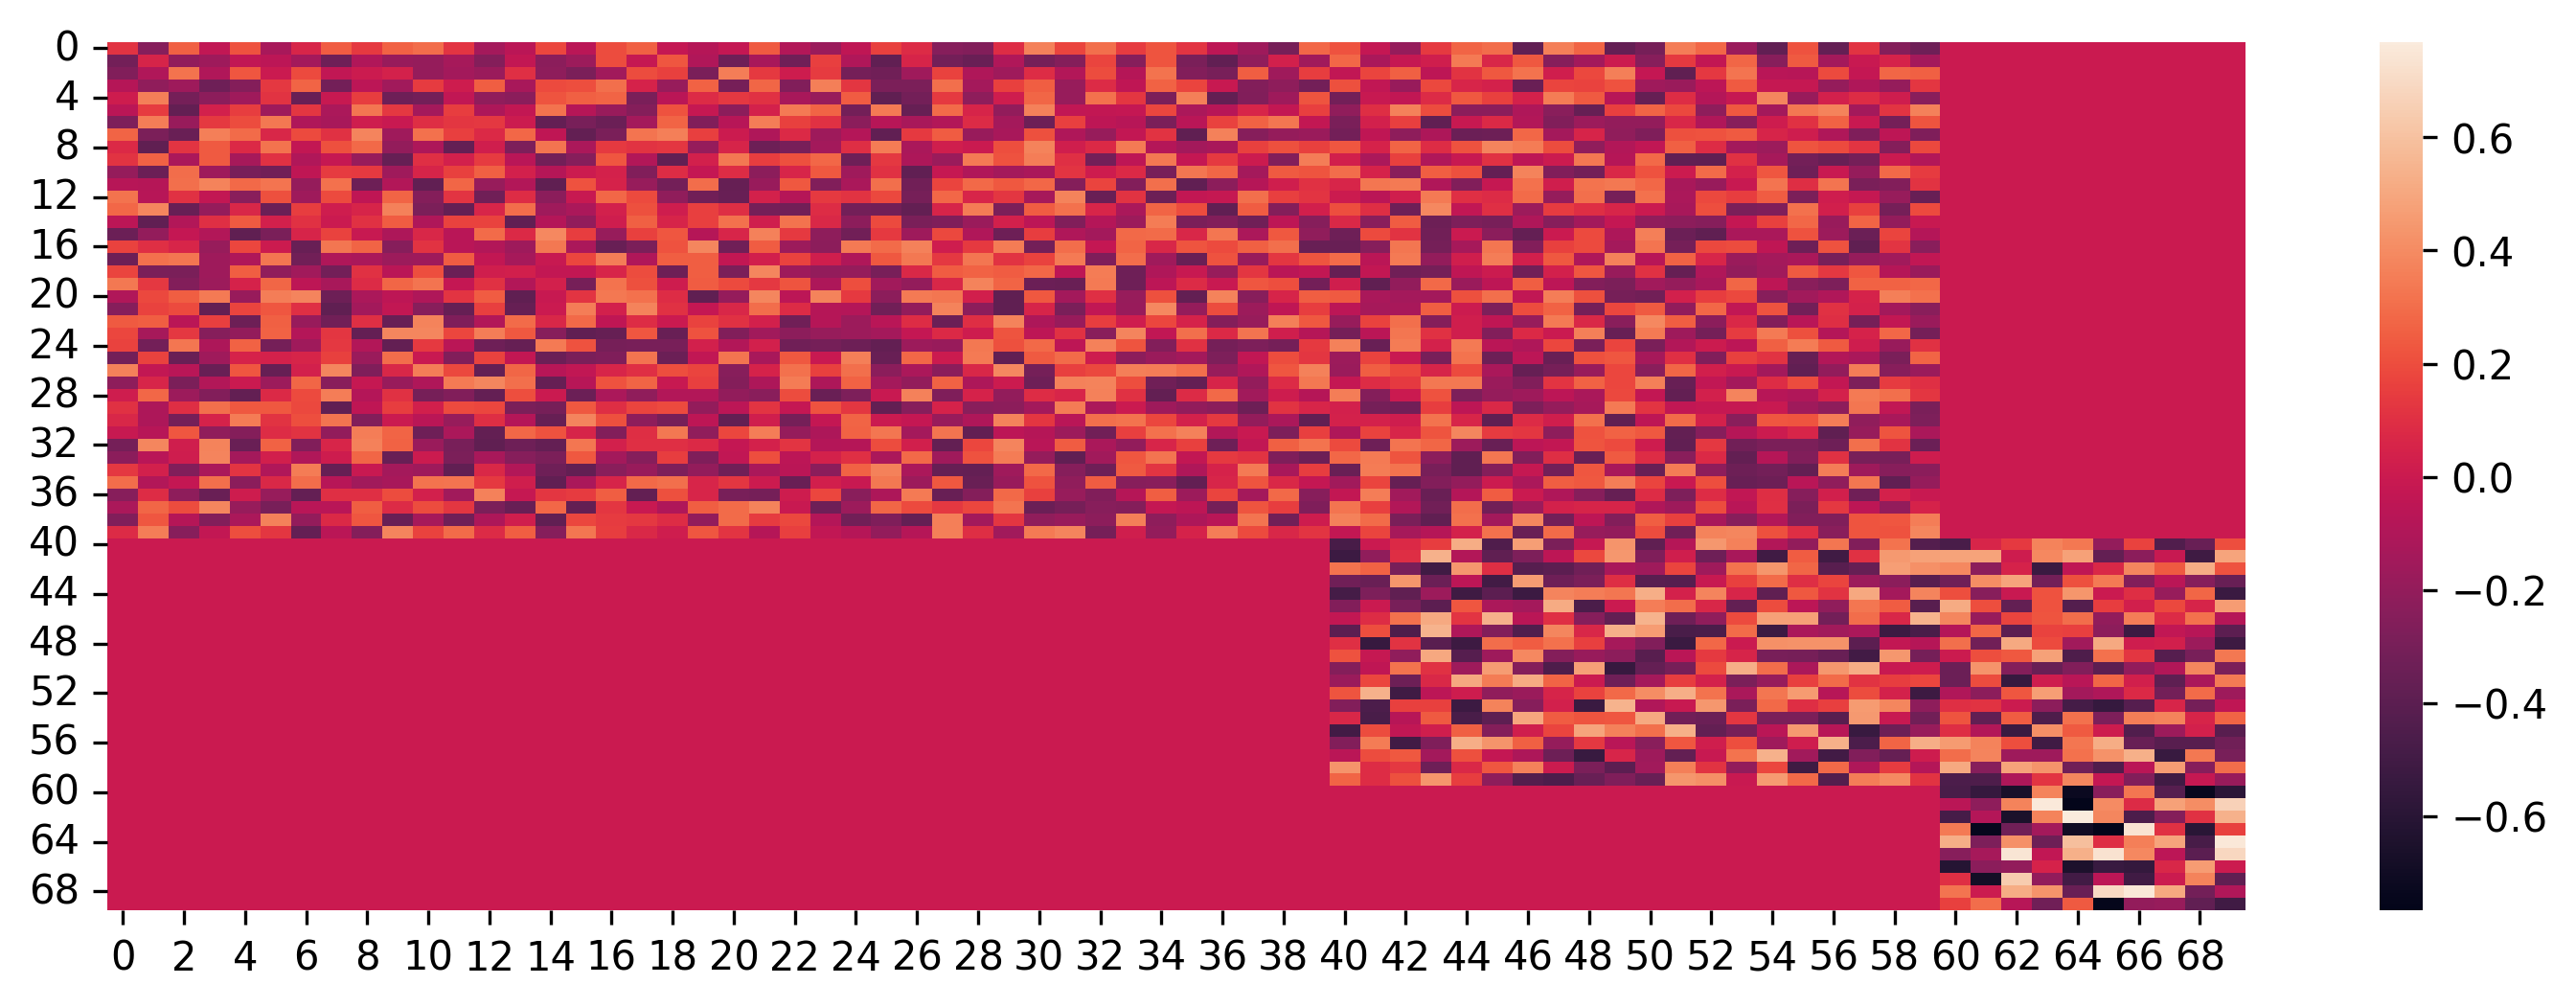

In [19]:
ax = sns.heatmap(_ms[1].weights)
plt.show()

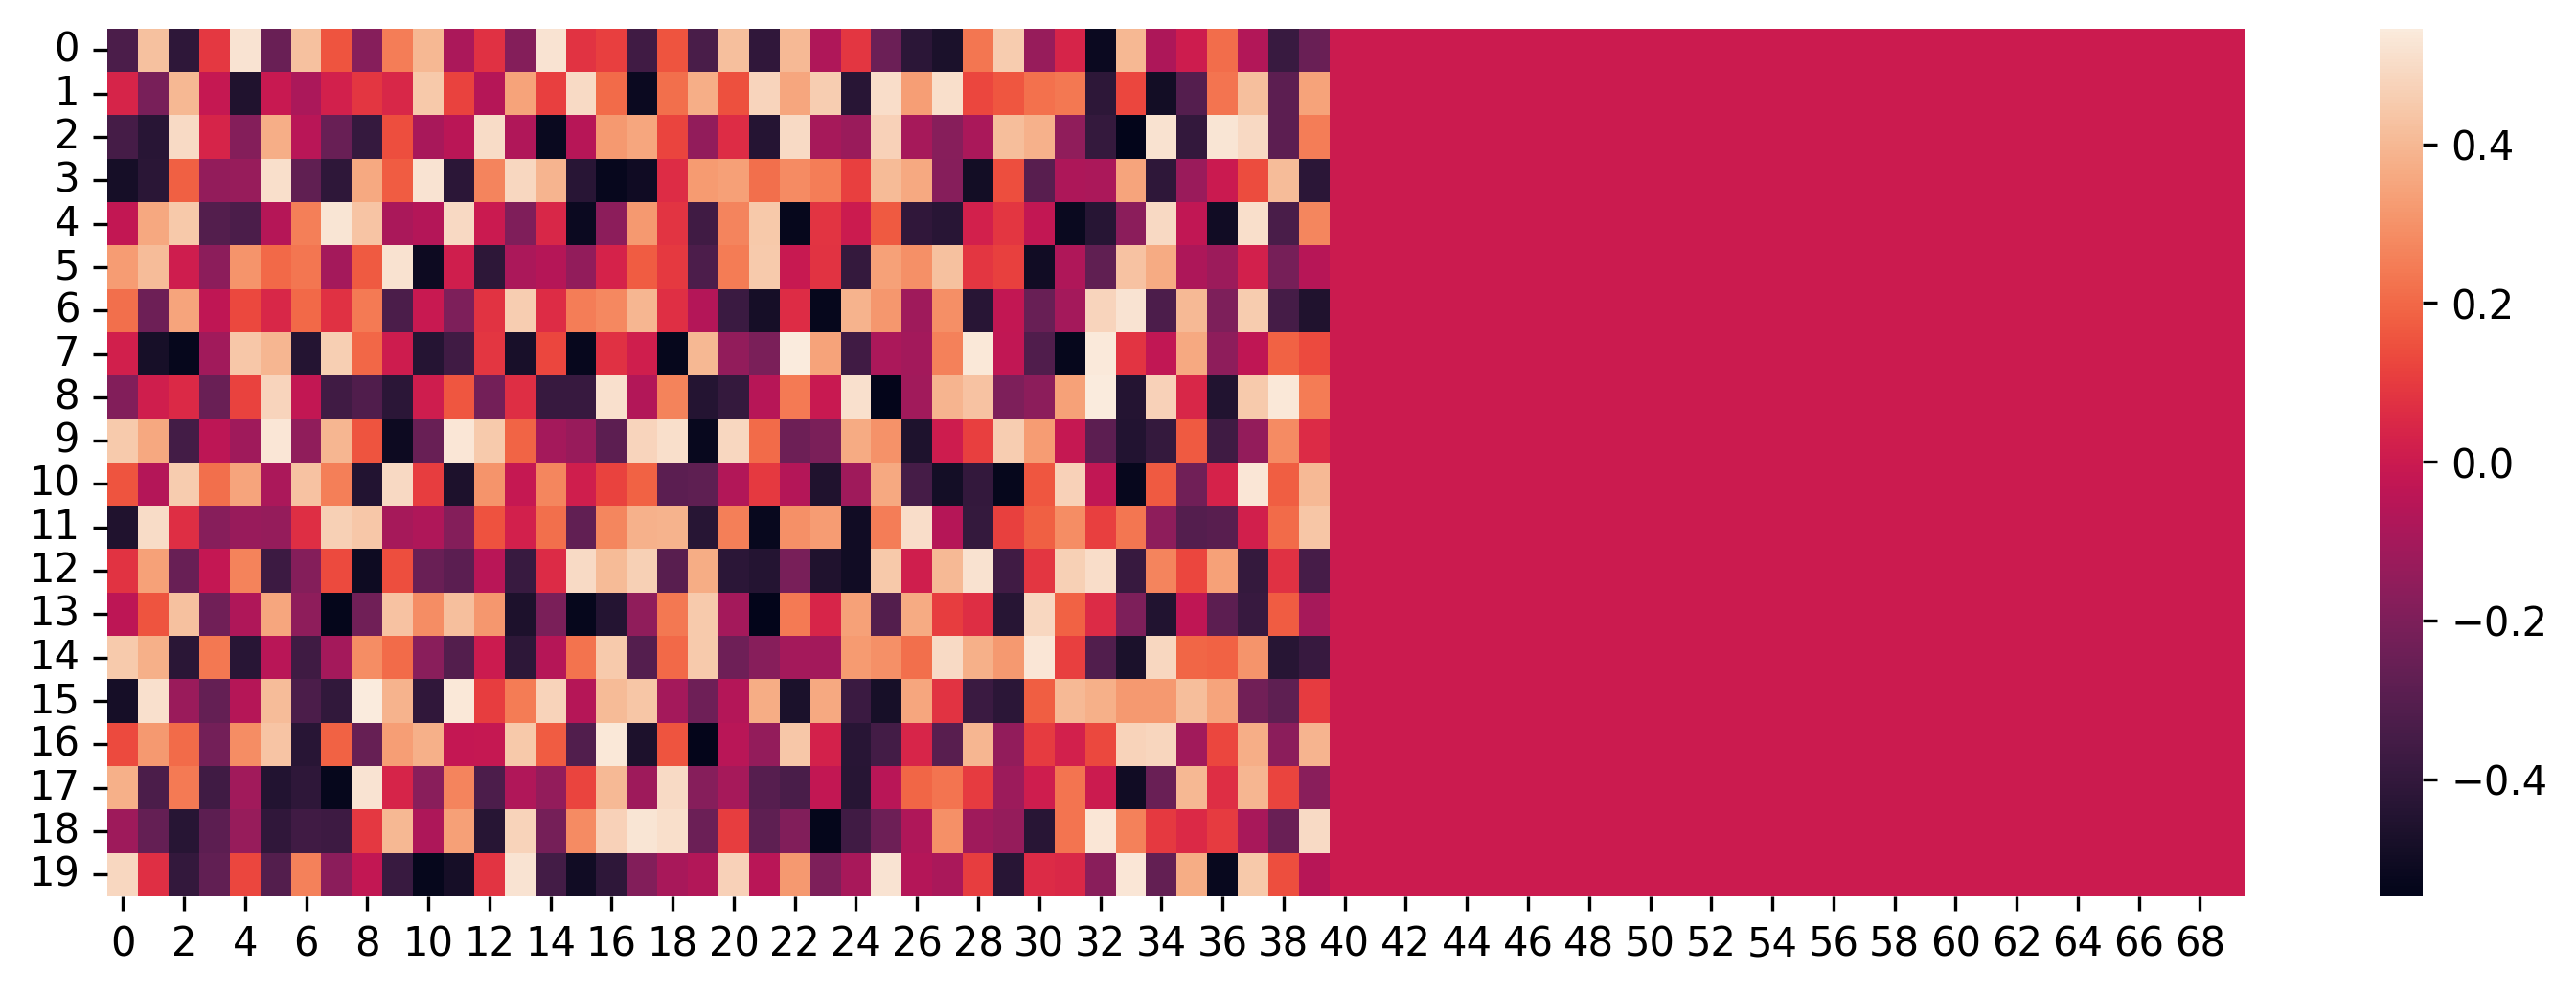

In [20]:
ax = sns.heatmap(_ms[0].weights)
plt.show()

In [21]:
mapper(mod_graph)

{'mapped_graph': GraphHolder "JaxSequential__11595850528_transformed_SE_11592449280" with 20 input nodes -> 70 output nodes,
 'weights_in': array([[-0.33112191,  0.42267885, -0.41106769, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.03615371, -0.21166878,  0.39718757, ...,  0.        ,
          0.        ,  0.        ],
        [-0.34630689, -0.43019971,  0.4951442 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.37824647, -0.33110883,  0.23915257, ...,  0.        ,
          0.        ,  0.        ],
        [-0.11917057, -0.26208295, -0.4341977 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.48843352,  0.06969859, -0.39811413, ...,  0.        ,
          0.        ,  0.        ]]),
 'weights_rec': array([[ 0.1116006 , -0.24755469,  0.25872403, ...,  0.        ,
          0.        ,  0.        ],
        [-0.31621215,  0.05078341, -0.20812091, ...,  0.        ,
          0.        ,  0.        ],
        [-0.264

In [22]:
mod_se = DynapseGraphWrapper.from_graph_holder(mod_trans).get_sequential()

In [23]:
mod_se

JaxSequential  with shape (20, 70) {
    LinearJax '0_LinearJax' with shape (20, 70)
    DynapSim '1_DynapSim' with shape (70, 70)
}

In [24]:
mod_se.reset_state()

# - Evolve with the frozen noise spiking input
tsOutput_se, new_state_se, record_dict_se = mod_se(input_sp_raster * input_scale, record = True)

In [25]:
record_dict_se["1_DynapSim"].keys()

dict_keys(['iahp', 'imem', 'isyn', 'spikes', 'vmem'])

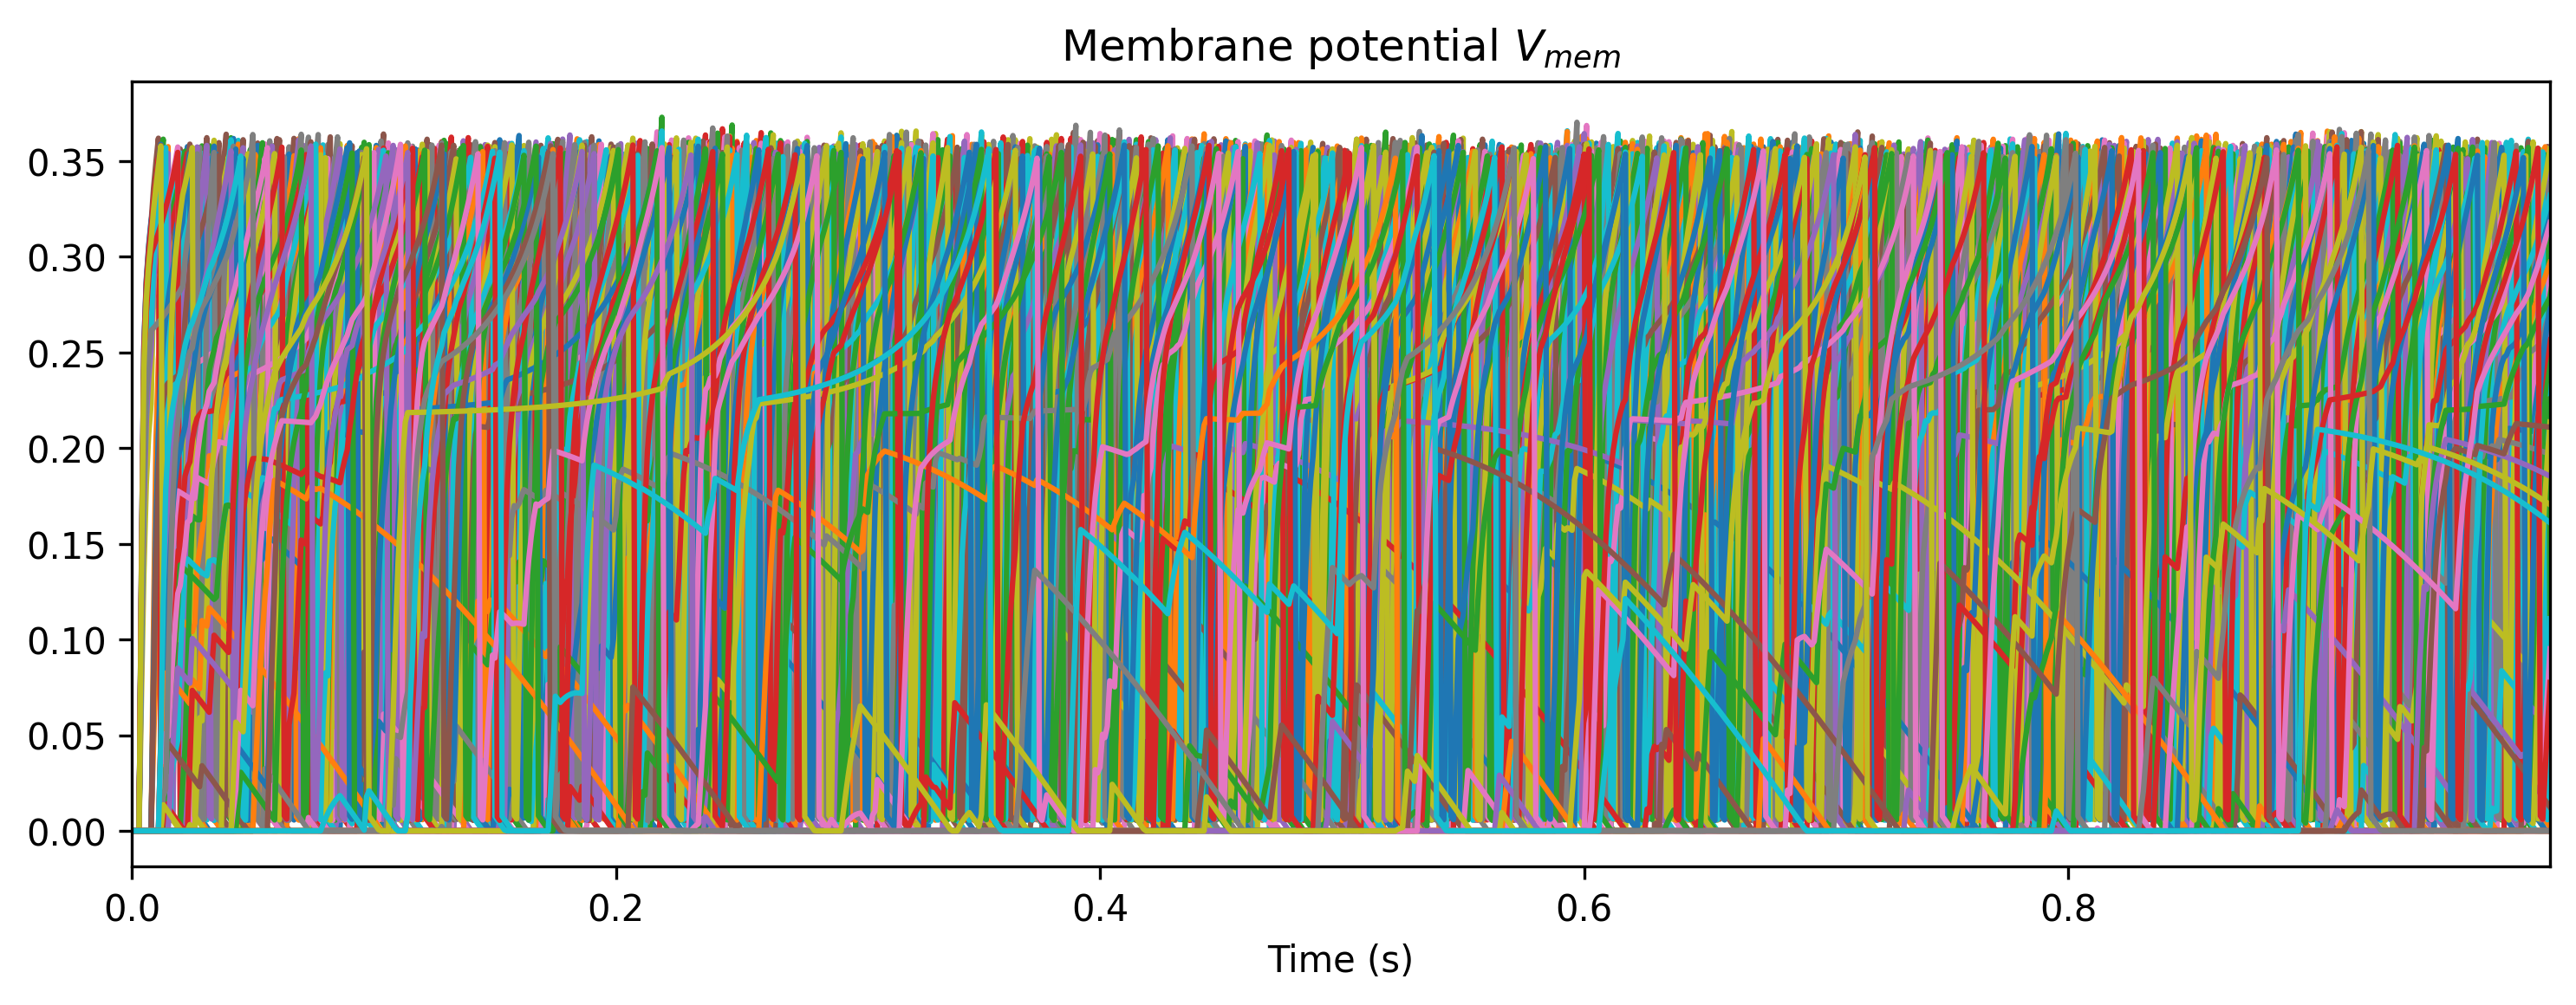

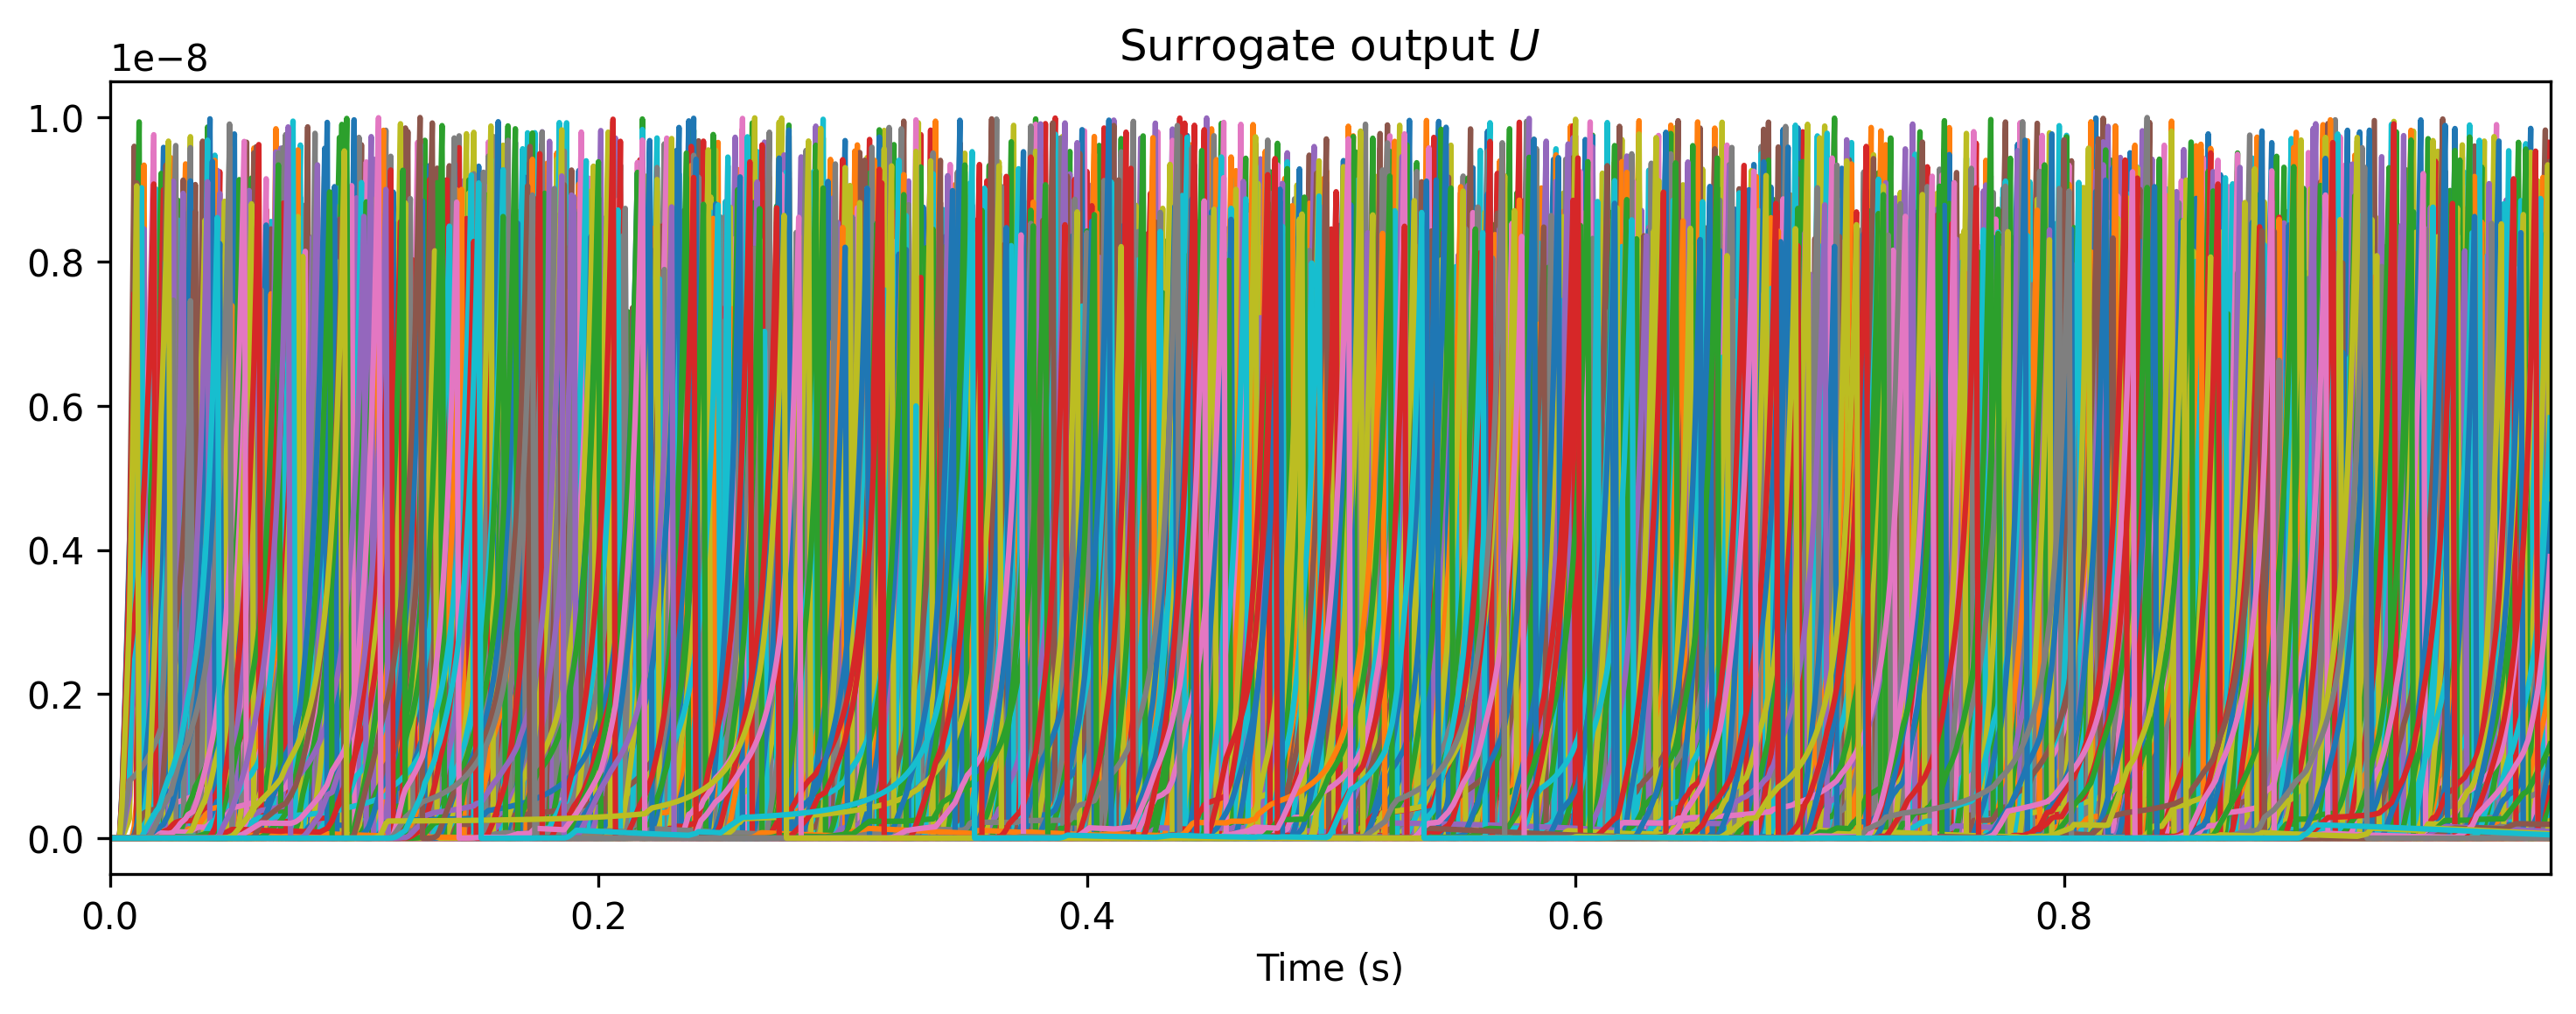

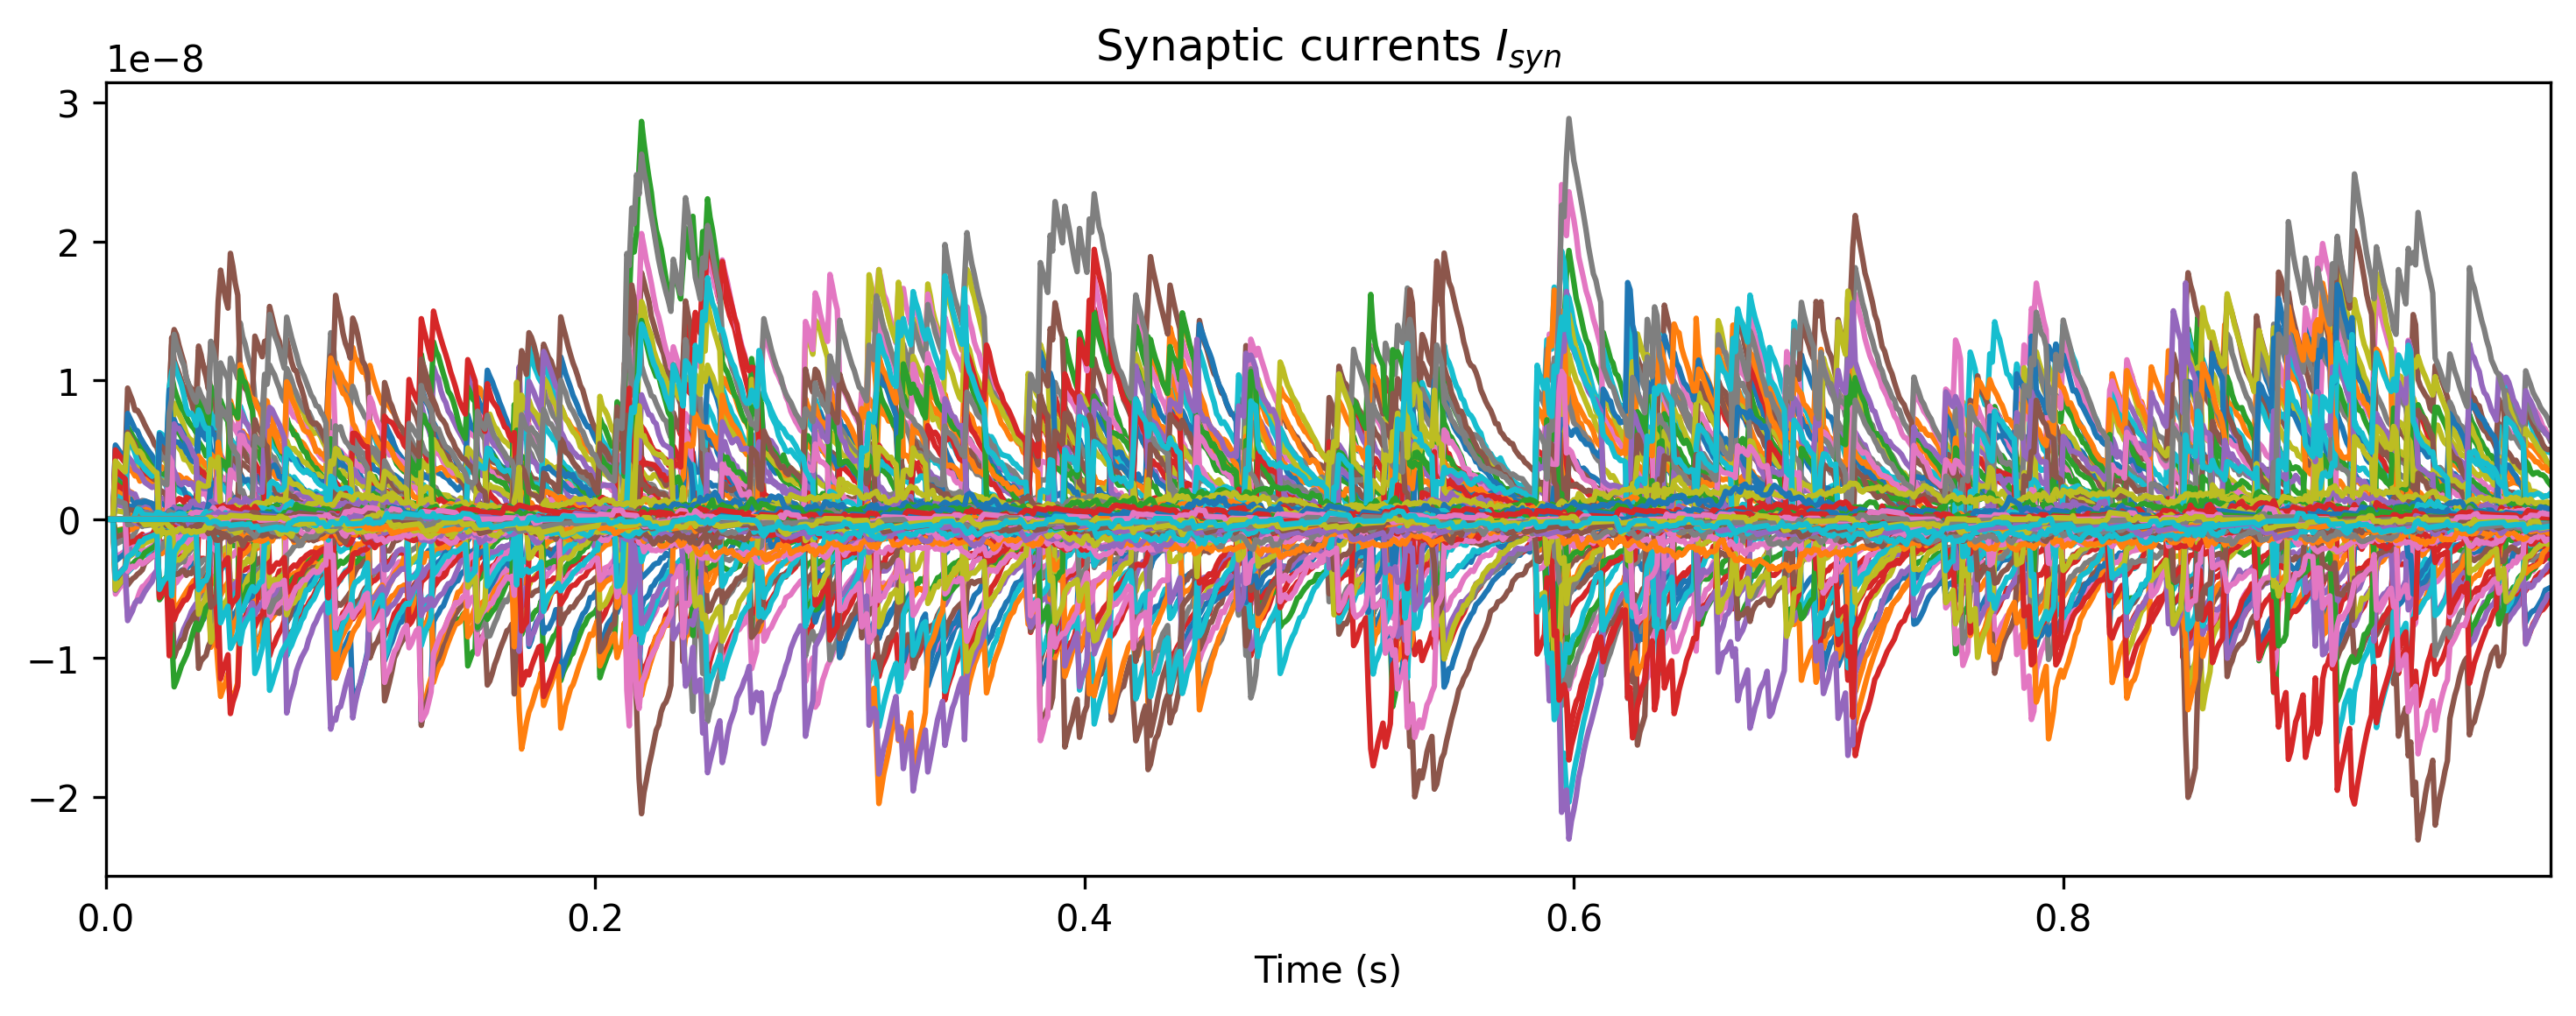

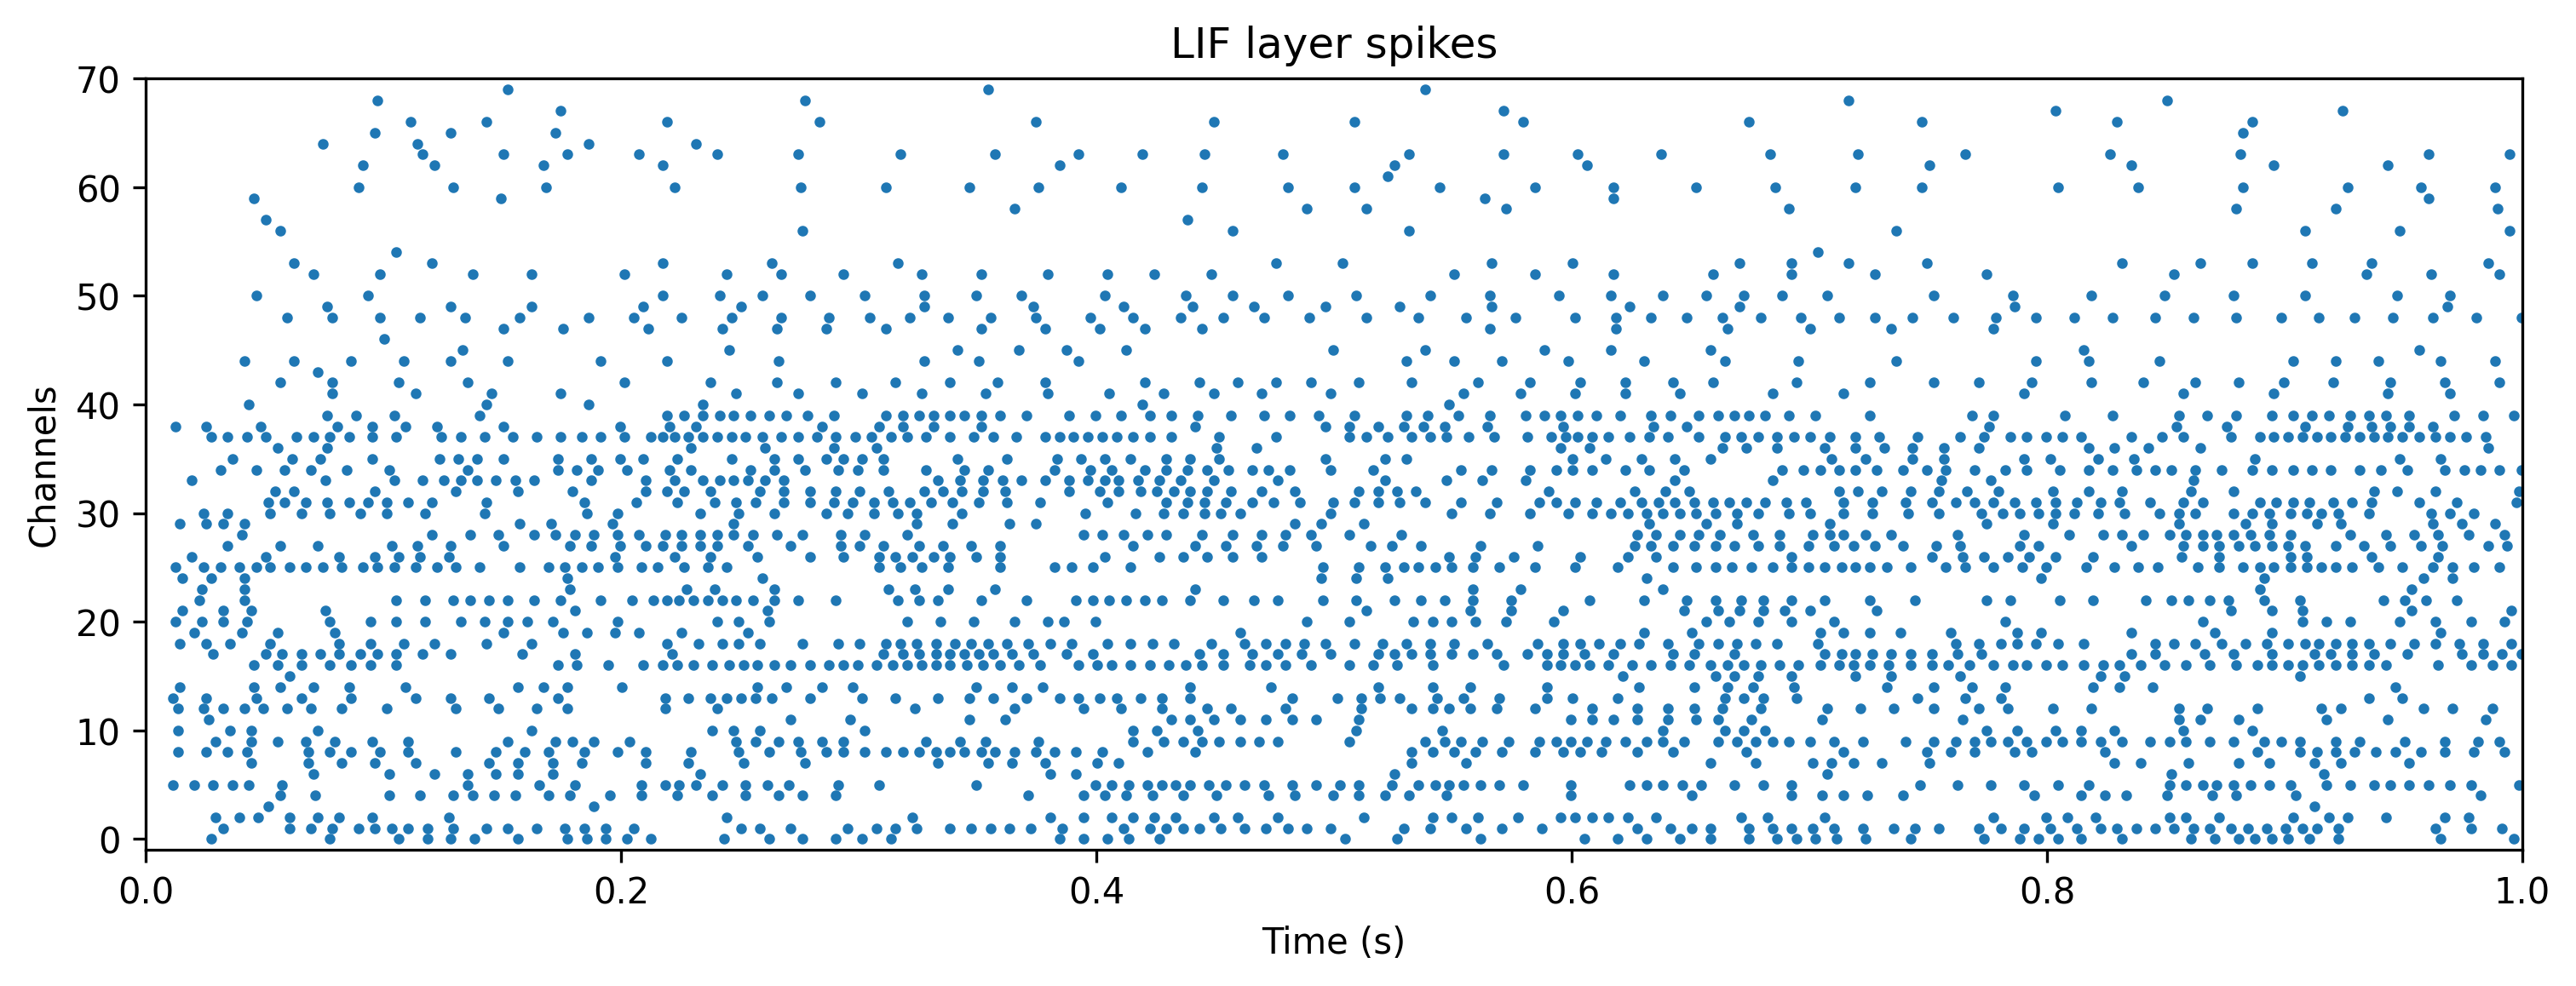

In [26]:
# - Make a function that converts ``record_dict``
def plot_record_dict2(rd):
    Vmem_ts = TSContinuous.from_clocked(rd['1_DynapSim']['vmem'][0], dt, name = 'Membrane potential $V_{mem}$')
    U_ts = TSContinuous.from_clocked(rd['1_DynapSim']['imem'][0], dt, name = 'Surrogate output $U$')
    Isyn_ts = TSContinuous.from_clocked(rd['1_DynapSim']['isyn'][0], dt, name = 'Synaptic currents $I_{syn}$')
    spikes_ts = TSEvent.from_raster(rd['1_DynapSim']['spikes'][0], dt, name = 'LIF layer spikes')

    # - Plot the internal activity of selected neurons
    plt.figure()
    Vmem_ts.plot()

    plt.figure()
    U_ts.plot()

    plt.figure()
    Isyn_ts.plot()

    plt.figure()
    spikes_ts.plot(s=4);
    
plot_record_dict2(record_dict_se)

In [27]:
mod_se[1].Iscale

1e-08

In [28]:
mod_se.as_graph() == mod_trans

False

In [29]:
n1, m1 = bag_graph(mod_trans)

In [30]:
n2, m2 = bag_graph(mod_se.as_graph())

In [31]:
m1[2].__dict__

{'input_nodes': [GraphNode 11591609760 with 2 source modules and 1 sink modules,
  GraphNode 11280158192 with 2 source modules and 1 sink modules,
  GraphNode 11280164960 with 2 source modules and 1 sink modules,
  GraphNode 11280163424 with 2 source modules and 1 sink modules,
  GraphNode 11541122736 with 2 source modules and 1 sink modules,
  GraphNode 11541127584 with 2 source modules and 1 sink modules,
  GraphNode 11541127872 with 2 source modules and 1 sink modules,
  GraphNode 11541128304 with 2 source modules and 1 sink modules,
  GraphNode 11541128880 with 2 source modules and 1 sink modules,
  GraphNode 11541127968 with 2 source modules and 1 sink modules,
  GraphNode 11541119904 with 2 source modules and 1 sink modules,
  GraphNode 11595229712 with 2 source modules and 1 sink modules,
  GraphNode 11595230048 with 2 source modules and 1 sink modules,
  GraphNode 11595229952 with 2 source modules and 1 sink modules,
  GraphNode 11595230624 with 2 source modules and 1 sink modu

In [32]:
m2[2].__dict__

{'input_nodes': [GraphNode 11885760080 with 2 source modules and 1 sink modules,
  GraphNode 11884966096 with 2 source modules and 1 sink modules,
  GraphNode 11884967680 with 2 source modules and 1 sink modules,
  GraphNode 11884965088 with 2 source modules and 1 sink modules,
  GraphNode 11884962304 with 2 source modules and 1 sink modules,
  GraphNode 11884962400 with 2 source modules and 1 sink modules,
  GraphNode 11884965520 with 2 source modules and 1 sink modules,
  GraphNode 11884959424 with 2 source modules and 1 sink modules,
  GraphNode 11884964032 with 2 source modules and 1 sink modules,
  GraphNode 11884966048 with 2 source modules and 1 sink modules,
  GraphNode 11884964752 with 2 source modules and 1 sink modules,
  GraphNode 11884964176 with 2 source modules and 1 sink modules,
  GraphNode 11884963936 with 2 source modules and 1 sink modules,
  GraphNode 11884960816 with 2 source modules and 1 sink modules,
  GraphNode 11884969744 with 2 source modules and 1 sink modu